In [6]:
def sir_11(X, y, num_slices, K):
    X = X - np.mean(X, axis = 0)
    n_samples, n_features = X.shape
    V_hat = np.zeros([X.shape[1], X.shape[1]])
    # Step 1: Sort the data by the response variable
    sorted_indices = np.argsort(y)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    # Step 2: Divide the data into slices
    slice_size = n_samples // num_slices
    ph_hat = slice_size/n_samples
    slices = []
    for i in range(num_slices):
        start_idx = i * slice_size
        if i < num_slices - 1:
            end_idx = (i + 1) * slice_size
        else:  # Last slice includes any remaining samples
            end_idx = n_samples
        slices.append((X_sorted[start_idx:end_idx], y_sorted[start_idx:end_idx]))
    # Step 3: Compute the means of the predictors within each slice
    X_means = np.array([np.mean(slice_X, axis=0) for slice_X, _ in slices])
    # Step 4: Center the predictor means
    X_centered = (X_means - np.mean(X, axis=0))
    # X_centered = (X_means - np.mean(X, axis=0))/np.linalg.norm(X_means - np.mean(X, axis=0))
    
    V_hat = np.add(V_hat,ph_hat * np.matmul(X_centered.T, X_centered))
    eigenvalues, eigenvectors = np.linalg.eig(V_hat)
    K_index = np.argpartition(np.abs(eigenvalues), X.shape[1]-K) >= X.shape[1]-K
    K_largest_eigenvectors = eigenvectors[:, K_index]
    edr_est =  K_largest_eigenvectors
    return edr_est, V_hat

## AR(1)

In [7]:
#add risk to be averaged over replicas, add prediction error for obj2 for averaged direction
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
def ave(arr, N):
    for i in range(len(arr)):
        arr[i] = arr[i]/N 
    return arr 
def compute_eigen(Q4, P, K):
    eigenvalues2, eigenvectors2 = np.linalg.eig(Q4)
    K_index = np.argpartition(np.abs(eigenvalues2), P - K) >= P - K
    K_largest_eigenvectors = eigenvectors2[:, K_index]
    edr_est = K_largest_eigenvectors  
    if edr_est[0] < 0:
        edr_est = -edr_est
    edr_est = edr_est / np.linalg.norm(edr_est)
    return edr_est
    
def proj(edr_est): 
    E = edr_est @ np.linalg.inv(edr_est.T @ edr_est) @ edr_est.T
    return E

def exhi(obj1):        
    array1 = np.vectorize(lambda x: f"{x:.6f}")(obj1)
    table = tabulate(array1, tablefmt='latex_raw')
    # Split the table into lines
    lines = table.split('\n')
    # Insert \hline after each row
    latex_table = '\n'.join([line + (' \\hline' if (idx > 1) else '') for idx, line in enumerate(lines)])
    print(latex_table)
    
from sklearn.model_selection import TimeSeriesSplit
def MSE(X, y):
    Mse = 0
    # Split using time series cross-validation (e.g., 5 splits)
    train_window = int(np.round(0.75 * len(X),0))  # Fixed size of training set (e.g., 75 time steps)
    test_window = 1   # Fixed size of test set (e.g., 25 time steps)
    # Sliding window cross-validation
    for i in range(0, len(X) - train_window - test_window + 1):
        # Define train and test windows
        X_train = X[i:i + train_window]
        y_train = y[i:i + train_window]
        X_test = X[i + train_window:i + train_window + test_window]
        y_test = y[i + train_window:i + train_window + test_window]
        model = LinearRegression()
        model.fit(X_train, y_train)
        # Make predictions
        y_pred = model.predict(X_test)
        # Calculate errors
        mse = mean_squared_error(y_test, y_pred)
        Mse += mse 
    Mse = Mse/(len(X) - train_window - test_window)
    return np.sqrt(Mse)

def optimal_values(arr):
    if len(arr) == 0:
        return None  # Handle the case of an empty array
    smallest = arr[0]  # Assume the first element is the smallest
    for num in arr:
        if num < smallest:
            smallest = num
    return smallest
   
def optimal_Q(arr):
    if len(arr) == 0:
        return None  # Handle the case of an empty array
    smallest = arr[0]  # Assume the first element is the smallest
    for num in arr:
        if num < smallest:
            smallest = num
    for i in range(len(arr)):
        if arr[i] == smallest:
            return i  # Return the first matched index
    return -1
def Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep):
    # n_obs < 1/2*n_gene, burn off 1/2*n_gene
    num_N = 5;P = 4;K = 1;n1 = 0;l = 1 
    noise1 = np.zeros((num_N, n_gene))
    noise2 = np.zeros((num_N, n_obs+S))
    y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
    X1 = [[np.zeros((num_N, n_obs)) for i in range(P)] for i in range(S)]
    obj_1 = [np.zeros((P, 1)) for _ in range(S)]  
    obj_2 = [np.zeros((P, 1)) for _ in range(S)]  
    prediction_mse_1 = [np.zeros((1, 1)) for _ in range(S)]
    prediction_mse_2 = [np.zeros((1, 1)) for _ in range(S)]
    M = [np.zeros((P, 1)) for _ in range(S)] 
    proj_error_1 = [np.zeros((1, )) for _ in range(S)] 
    proj_error_2 = [np.zeros((1, )) for _ in range(S)] 
    error_1 = [np.zeros((1, )) for _ in range(S)]
    error_2 = [np.zeros((1, )) for _ in range(S)]
    g = np.zeros((S, 1))
    g1 = np.zeros((S, 1))
    g2 = np.zeros((S, 1))
    projection_1_norm = np.zeros((S, 1))
    projection_2_norm = np.zeros((S, 1))
    True_projection = np.array([[2],[3],[0],[0]])/((np.linalg.norm(np.array([[2],[3],[0],[0]]))))
    obj_2_avevec = [np.zeros((P, 1)) for _ in range(S)]
    obj2_ave = np.zeros((P, 1))
    
    Exhi_1 = [np.zeros((P, 1)) for _ in range(S)]
    Exhi_2 = [np.zeros((P, 1)) for _ in range(S)]
    exhi_1 = [np.zeros((P, 1)) for _ in range(S)]
    exhi_2 = [np.zeros((P, 1)) for _ in range(S)]

    error_11 = 0
    prediction_mse_11 = 0
    proj_error_11 = 0
    while n1 < n_rep:  
        obj_2 = [np.zeros((P, 1)) for _ in range(S)]
        obj_2_avevec = [np.zeros((P, 1)) for _ in range(S)]
        # Data Generation
        for h in range(num_N):
            noise1[h] = np.random.normal(0, 1, size=(n_gene)) 
            noise2[h] = np.random.normal(0, 1, size=(n_obs+S))
            # noise[h] = np.random.normal(0, 0.5, size=(n_obs+S))
        ar_series = np.zeros((num_N, n_obs+S+1))
        # change initial value and burn-off?
        for i in range(num_N):
            ar_series[i][0] = initial_value  
        AR1 = initial_value
        AR2 = initial_value
        AR3 = initial_value
        AR4 = initial_value
        for t in range(1, n_gene + 1):
            AR1 = ar_coeff[0] * AR1 + noise1[0][t-1]
            AR2 = ar_coeff[1] * AR2 + noise1[1][t-1]
            AR3 = ar_coeff[2] * AR3 + noise1[2][t-1]
            AR4 = ar_coeff[3] * AR4 + noise1[3][t-1]
        ar_series[0][0] = AR1 
        ar_series[1][0] = AR2 
        ar_series[2][0] = AR3 
        ar_series[3][0] = AR4 
        for t in range(1, n_obs+S+1): 
            ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + noise2[0][t - 1]
            ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + noise2[1][t - 1]
            ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + noise2[2][t - 1]
            ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + noise2[3][t - 1]
            ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise2[4][t-1]
        
        for a in range(0, S):
            y[a] = ar_series[4][a:n_obs+a]
            X1[a] = np.concatenate([ar_series[i][a:n_obs+a].reshape(-1, 1) for i in range(P)], axis = 1)
        X = X1[0]
        edr_est1, M1 = sir_11(X, y[0], H, K)
        edr_est1 = compute_eigen(np.linalg.inv(np.cov(X.T)) @ M1 @ np.linalg.inv(np.cov(X.T)), P, K)
        if edr_est1[0] < 0:
            edr_est1 = -edr_est1
        edr_est1 = np.real(edr_est1 / np.linalg.norm(edr_est1))
        error_11 += abs(edr_est1[0] / edr_est1[1] - a1/a2)
        prediction_mse_11 += MSE(X @ edr_est1, y[0]) 
        proj_error_11 += np.linalg.norm((proj(edr_est1) - proj(True_projection)), 'fro')**2
        V1 = []
        for a in range(0, S):
            _, M = sir_11(X, y[a], H, K)
            V1.append(M)
    # objective 1: experiment
        for q in range(0, S):
            phi = ar_coeff
            Q3 = np.zeros((P, P))
            for j in range(P):
                for k in range(P):
                    Q3[j, k] = sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(0, q + 1))
            edr_est = compute_eigen(Q3, P, K)
            if edr_est[0] < 0:
                edr_est = -edr_est
            edr_est = edr_est / np.linalg.norm(edr_est)
           
            error_1[q] += abs(edr_est[0] / edr_est[1] - a1/a2)
            prediction_mse_1[q] += MSE(X @ edr_est, y[0]) 
            proj_error_1[q] += np.linalg.norm((proj(edr_est) - proj(True_projection)), 'fro')**2
            
     # objective 2: experiment
        for q in range(0, S):
            Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
            # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
            K_largest_eigenvectors = compute_eigen(Q4, P, K)
            edr_est = np.multiply(np.power(ar_coeff, -q), K_largest_eigenvectors.flatten())   
            if edr_est[0] < 0:
                edr_est = -edr_est
            edr_est = edr_est / np.linalg.norm(edr_est)
            obj_2[q] += edr_est.reshape(-1, 1)    
            
        # Average among lags Q
        for j in range(S):
            for i in range(j, S, 1):
                obj_2_avevec[i] += obj_2[j]
        for j in range(S):
            obj_2_avevec[j] = ave(obj_2_avevec[j], j + 1)
            
        for q in range(0, S):
            error_2[q] += abs(obj_2_avevec[q][0] / obj_2_avevec[q][1] - a1/a2)
            prediction_mse_2[q] += MSE(X @ obj_2_avevec[q], y[0])
            proj_error_2[q] += np.linalg.norm((proj(obj_2_avevec[q]) - proj(True_projection)), 'fro')**2          
        n1 += 1    
        
    error_1 = ave(error_1, n_rep)    
    error_2 = ave(error_2, n_rep)
    prediction_mse_1 = ave(prediction_mse_1, n_rep)
    prediction_mse_2 = ave(prediction_mse_2, n_rep)
    proj_error_1 = ave(proj_error_1, n_rep)
    proj_error_2 = ave(proj_error_2, n_rep)
    SIR_values = [error_1[0], prediction_mse_1[0], proj_error_1[0]]
    obj1_optimal_values = [optimal_values(error_1), optimal_values(prediction_mse_1), optimal_values(proj_error_1)]
    obj2_optimal_values = [optimal_values(error_2), optimal_values(prediction_mse_2), optimal_values(proj_error_2)]
    obj1_optimal_Q = [optimal_Q(error_1),optimal_Q(prediction_mse_1),optimal_Q(proj_error_1)]
    obj2_optimal_Q = [optimal_Q(error_2),optimal_Q(prediction_mse_2),optimal_Q(proj_error_2)]

    index_array = list(range(len(obj_1)))
    for i in range(S):
        exhi_1[i] = error_1[i]
        exhi_1[i] = np.vstack((exhi_1[i], proj_error_1[i]))
        exhi_1[i] = np.vstack((exhi_1[i], prediction_mse_1[i]))
        exhi_1[i] = np.vstack((np.array([[index_array[i]]]), exhi_1[i]))

    for i in range(S):
        exhi_2[i] = error_2[i]
        exhi_2[i] = np.vstack((exhi_2[i], proj_error_2[i]))
        exhi_2[i] = np.vstack((exhi_2[i], prediction_mse_2[i]))
        exhi_2[i] = np.vstack((np.array([[index_array[i]]]), exhi_2[i]))
    #     obj_1[i] = np.vstack((obj_1[i], g[i].reshape(1,-1)))
    #     obj_1[i] = np.vstack((np.array([[index_array[i]]]), obj_1[i])) 
    #     obj_1[i] = np.vstack((np.array(obj_1[i]), proj_error_1[i])) 
    #     obj_1[i] = np.vstack((np.array(obj_1[i]), mse[i]))  
    #objective 1: exhibition
    # for i in range(S):
    #     g[i] = abs(obj_1[i][0] / obj_1[i][1] - a1/a2)
    #     obj_1[i] = np.vstack((obj_1[i], g[i].reshape(1,-1)))
    #     obj_1[i] = np.vstack((np.array([[index_array[i]]]), obj_1[i])) 
    #     obj_1[i] = np.vstack((np.array(obj_1[i]), proj_error_1[i])) 
    #     obj_1[i] = np.vstack((np.array(obj_1[i]), mse[i]))    
    # Result1 = [g[0] - min(g), projection1_norm[0] - min(projection1_norm), mse[0] - min(mse)]
    # Result1 = [x.item() for x in Result1]   
    #objective 2: exhibition
    
    # for i in range(S):
    #     g[i] = abs(obj2[i][0] / obj2[i][1] - a1/a2)
    #     projection2_norm[i] = np.linalg.norm(proj2[i] - proj(True_projection), 'fro')
    #     obj2[i] = np.vstack((obj_2_avevec[i], g[i].reshape(1,-1)))
    #     obj2[i] = np.vstack((np.array([[index_array[i]]]), obj_2_avevec[i]))    
    #     obj2[i] = np.vstack((np.array(obj2[i]), projection2_norm[i]))
    #     obj2[i] = np.vstack((np.array(obj2[i]), mse2[i]))
    #     obj2[i] = np.vstack((np.array(obj2[i]), abs(obj_2_avevec[i][0]/obj_2_avevec[i][1] - 2/3)))
    #     obj2[i] = np.vstack((np.array(obj2[i]), np.linalg.norm(proj(obj_2_avevec[i]) - proj(True_projection), 'fro')))
    #     obj2[i] = np.vstack((np.array(obj2[i]), Mse1(X @ obj_2_avevec[i], y[0])))
    
    # for i in range(S):
    #     g[i] = abs(obj_2_avevec[i][0] / obj_2_avevec[i][1] - a1/a2)
    #     g1[i] = proj_error_2[i]
    #     g2[i] = Mse1(X @ obj_2_avevec[i], y[0])
    #     obj_2_avevec[i] = np.vstack((obj_2_avevec[i], g[i].reshape(1,-1)))
    #     obj_2_avevec[i] = np.vstack((np.array([[index_array[i]]]), obj_2_avevec[i]))    
    #     obj_2_avevec[i] = np.vstack((obj_2_avevec[i], g1[i]))
    #     obj_2_avevec[i] = np.vstack((obj_2_avevec[i], g2[i]))
    # Result2 = [g[0] - min(g), g1[0] - min(g1), g2[0] - min(g2)] 
    # Result2 = [x.item() for x in Result2]
    # print("error_1:",[x.item() for x in error_1])
    # print("error_2:",[x.item() for x in error_2])
    # print("proj_error_1:",[x.item() for x in proj_error_1]) 
    # print("proj_error_2:",[x.item() for x in proj_error_2])
    # print(obj_2_avevec)
    # print(obj_2)
    # print("Obj1")
    # exhi(obj1) 
    # print("Obj2")
    # exhi(obj_2_avevec)
    # print(Result1), print(Result2)
    # return obj_2_avevec
    # Tables
    # print("Obj1")
    # exhi(exhi_1)
    # print("Obj2")
    # exhi(exhi_2)
    return prediction_mse_1

In [10]:
ar_coeff = [0.2, 0.5, 0.1, 0.1];a1=2; a2=3; initial_value = 0; n_gene = 10000; n_obs = 100; H = 5; S=10; n_rep = 5
prediction_mse_1 = Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)
prediction_mse_1

[array([[0.99632066]]),
 array([[0.97825198]]),
 array([[0.97722876]]),
 array([[0.97708004]]),
 array([[0.97706031]]),
 array([[0.97705753]]),
 array([[0.97705598]]),
 array([[0.97705537]]),
 array([[0.97705507]]),
 array([[0.97705505]])]

In [97]:
ar_coeff = [0.2, 0.2, 0.1, 0.1];a1=2; a2=3; initial_value = 0; n_gene = 10000; n_obs = 1000; H = 50; S=10; n_rep = 100
SIR_values, obj1_optimal_values, obj2_optimal_values, obj1_optimal_Q, obj2_optimal_Q = Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)
SIR_values, obj1_optimal_values, obj2_optimal_values, obj1_optimal_Q, obj2_optimal_Q

([array([0.39634516]), array([[3.77277028]]), array([0.43827567])],
 [array([0.14304268]), array([[3.76575315]]), array([0.09679428])],
 [array([0.39634516]), array([[3.76828455]]), array([0.16122779])],
 [2, 9, 9],
 [0, 1, 1])

In [68]:
# ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep
# _, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q
import pandas as pd
# Parameters
x = np.random.rand(10, 10)
n_samples = [100, 1000, 10000]
objectives = ["Objective 1", "Objective 2"]
H = 5
# ar_coefficients = [(0.8, 0.8, 0.1, 0.1), (0.6, 0.6, 0.1, 0.1), (0.4, 0.4, 0.1, 0.1), (0.2, 0.2, 0.1, 0.1), (0.8, 0.8, 0.8, 0.8), (0.6, 0.6, 0.6, 0.6), (0.4, 0.4, 0.4, 0.4), (0.2, 0.2, 0.2, 0.2)]
ar_coefficients = [(0.8, 0.8, 0.1, 0.1)]
replicas_dict = {100: 100, 1000: 100, 10000: 100}
# replicas_dict = {100: 500, 1000: 100, 10000: 100}
# Prepare a structured data list
table_entries = []
# Iterate over all combinations
for samples in n_samples:
    for ar_coeff in ar_coefficients:
        # Run the experiment
        n_rep = replicas_dict[samples]
        _, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q = Test1(ar_coeff, 2, 3, 0, 10000, samples, 5, 10, n_rep)
        for objective in objectives:
            if objective == "Objective 1":    # Store the result in a structured manner
                table_entries.append({
                    'samples': samples,
                    'objective': objective,
                    'ar_coeff': ar_coeff,
                    'absolute_error optimal_Q': Obj1_optimal_Q[0],
                    'risk optimal_Q': Obj1_optimal_Q[1],
                    'prediction_error optimal_Q': Obj1_optimal_Q[2],
                    'absolute_error': float(f"{Obj1_optimal_values[0][0]:.4f}"),
                    'risk': float(f"{Obj1_optimal_values[2][0]:.4f}"),
                    'prediction_error': float(f"{Obj1_optimal_values[1][0][0]:.4f}")
                })
            else:
                table_entries.append({
                    'samples': samples,
                    'objective': objective,
                    'ar_coeff': ar_coeff,
                    'absolute_error optimal_Q': Obj2_optimal_Q[0],
                    'risk optimal_Q': Obj2_optimal_Q[1],
                    'prediction_error optimal_Q': Obj2_optimal_Q[2],
                    'absolute_error': float(f"{Obj2_optimal_values[0][0]:.4f}"),
                    'risk': float(f"{Obj2_optimal_values[2][0]:.4f}"),
                    'prediction_error': float(f"{Obj2_optimal_values[1][0][0]:.4f}")
                })             
# Create a DataFrame
df = pd.DataFrame(table_entries)
# Construct LaTeX table manually
latex_table = r"""Full Factorial Design for Samples, Objectives, AR Coefficients, Optimal Lag $Q$ and Measure Values for $AR(1)$ process. Number of slices $H = 5$. Number of replicas $n_{replicas} = 100$ for number of samples $n_{samples} = 100$, $n_{replicas} = 100$ for $n_{samples} = 1000$ and $n_{replicas} = 100$ for $n_{samples} = 10000$.\resizebox{1\textwidth}{!}{\begin{tabular}{cccccccc}
\toprule
\multirow{2}{*}{\textbf{Number of Samples}} & \multirow{2}{*}{\textbf{Objective}} & \multirow{2}{*}{\textbf{AR Coefficients}} & \multicolumn{3}{c}{\textbf{Optimal $Q$ and Measure Values}} \\
\cmidrule(lr){4-6}
 & & & \textbf{Absolute Error} & \textbf{Risk} & \textbf{Prediction Error (MSE)} \\
\midrule
"""
# Add entries to the LaTeX table
subset = df[(df['samples'] == 100) & (df['objective'] == "Objective 1")]
for samples in n_samples:
    latex_table += f"\\multirow{{{len(subset)}}}{{*}}{{{samples}}}"
    for objective in objectives:
        multirow_added2 = False
        # Filter the entries for this sample and objective
        subset = df[(df['samples'] == samples) & (df['objective'] == objective)]
        for idx, row in subset.iterrows():
            if not multirow_added2:  # Add multi-row for the first entry
                latex_table += f" & \\multirow{{{len(subset)}}}{{*}}{{{objective}}} & {row['ar_coeff']} & ({row['absolute_error optimal_Q']}, {row['absolute_error']}) & ({row['risk optimal_Q']}, {row['risk']}) & ({row['prediction_error optimal_Q']}, {row['prediction_error']}) \\\\\n"
                multirow_added2 = True
            else:
                latex_table += f" & & {row['ar_coeff']} & ({row['absolute_error optimal_Q']}, {row['absolute_error']}) & ({row['risk optimal_Q']}, {row['risk']}) & ({row['prediction_error optimal_Q']}, {row['prediction_error']}) \\\\\n"
        if objective != objectives[-1]:
            latex_table += "\\cmidrule(lr){2-6} \n"
    if samples != n_samples[-1]:
        latex_table += "\\midrule\n"

# Close the table
latex_table += r"""\bottomrule
\end{tabular}
}
\end{table}"""
# Print the LaTeX table
print(latex_table)

Full Factorial Design for Samples, Objectives, AR Coefficients, Optimal Lag $Q$ and Measure Values for $AR(1)$ process. Number of slices $H = 5$. Number of replicas $n_{replicas} = 100$ for number of samples $n_{samples} = 100$, $n_{replicas} = 100$ for $n_{samples} = 1000$ and $n_{replicas} = 100$ for $n_{samples} = 10000$.\resizebox{1\textwidth}{!}{\begin{tabular}{cccccccc}
\toprule
\multirow{2}{*}{\textbf{Number of Samples}} & \multirow{2}{*}{\textbf{Objective}} & \multirow{2}{*}{\textbf{AR Coefficients}} & \multicolumn{3}{c}{\textbf{Optimal $Q$ and Measure Values}} \\
\cmidrule(lr){4-6}
 & & & \textbf{Absolute Error} & \textbf{Risk} & \textbf{Prediction Error (MSE)} \\
\midrule
\multirow{1}{*}{100} & \multirow{1}{*}{Objective 1} & (0.8, 0.8, 0.1, 0.1) & (2, 0.0754) & (1, 0.0231) & (9, 14.3736) \\
\cmidrule(lr){2-6} 
 & \multirow{1}{*}{Objective 2} & (0.8, 0.8, 0.1, 0.1) & (9, 0.0853) & (0, 0.1691) & (0, 14.6442) \\
\midrule
\multirow{1}{*}{1000} & \multirow{1}{*}{Objective 1} & (0.

In [ ]:
# ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep
# _, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q
import pandas as pd
x_values = np.arange(0.1, 1, 0.1)
x_grid = np.array(np.meshgrid(x_values, x_values)).T.reshape(-1, 2)
x_grid = np.round(x_grid, 1)
n_samples = [100, 1000, 10000]
objectives = ["Objective 1", "Objective 2"]
H = 5
ar_coefficients =  [ 
    [x_pair[0], x_pair[1], 0.2, 0.2] for x_pair in x_grid
] + [
    [x_pair[0], x_pair[1], 0.5, 0.5] for x_pair in x_grid
] + [
    [x_pair[0], x_pair[1], 0.8, 0.8] for x_pair in x_grid
]
replicas_dict = {100: 100, 1000: 100, 10000: 100}
# Prepare a structured data list
table_entries = []

# Iterate over all combinations
for samples in n_samples:
    for ar_coeff in ar_coefficients:
        # Run the experiment
        n_rep = replicas_dict[samples]
        _, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q = Test1(ar_coeff, 2, 3, 10000, 1000, samples, 5, 10, n_rep)
        for objective in objectives:
            if objective == "Objective 1":    # Store the result in a structured manner
                table_entries.append({
                    'samples': samples,
                    'objective': objective,
                    'ar_coeff': ar_coeff,
                    'absolute_error optimal_Q': Obj1_optimal_Q[0],
                    'risk optimal_Q': Obj1_optimal_Q[1],
                    'prediction_error optimal_Q': Obj1_optimal_Q[2],
                    'absolute_error': float(f"{Obj1_optimal_values[0][0]:.4f}"),
                    'risk': float(f"{Obj1_optimal_values[2][0]:.4f}"),
                    'prediction_error': float(f"{Obj1_optimal_values[1][0][0]:.4f}")
                })
            else:
                table_entries.append({
                    'samples': samples,
                    'objective': objective,
                    'ar_coeff': ar_coeff,
                    'absolute_error optimal_Q': Obj2_optimal_Q[0],
                    'risk optimal_Q': Obj2_optimal_Q[1],
                    'prediction_error optimal_Q': Obj2_optimal_Q[2],
                    'absolute_error': float(f"{Obj2_optimal_values[0][0]:.4f}"),
                    'risk': float(f"{Obj2_optimal_values[2][0]:.4f}"),
                    'prediction_error': float(f"{Obj2_optimal_values[1][0][0]:.4f}")
                })
                  
# Create a DataFrame
df = pd.DataFrame(table_entries)
# Construct LaTeX table manually
latex_table = r"""Full Factorial Design for Samples, Objectives, AR Coefficients, Optimal Lag $Q$ and Measure Values for $AR(1)$ process. Number of slices $H = 5$. Number of replicas $n_{replicas} = 100$ for number of samples $n_{samples} = 100$, $n_{replicas} = 100$ for $n_{samples} = 1000$ and $n_{replicas} = 100$ for $n_{samples} = 10000$.\resizebox{1\textwidth}{!}{\begin{tabular}{cccccccc}
\toprule
\multirow{2}{*}{\textbf{Number of Samples}} & \multirow{2}{*}{\textbf{Objective}} & \multirow{2}{*}{\textbf{AR Coefficients}} & \multicolumn{3}{c}{\textbf{Optimal $Q$ and Measure Values}} \\
\cmidrule(lr){4-6}
 & & & \textbf{Absolute Error} & \textbf{Risk} & \textbf{Prediction Error (MSE)} \\
\midrule
"""
# Add entries to the LaTeX table
subset = df[(df['samples'] == 100) & (df['objective'] == "Objective 1")]
for samples in n_samples:
    latex_table += f"\\multirow{{{len(subset)}}}{{*}}{{{samples}}}"
    for objective in objectives:
        multirow_added2 = False
        # Filter the entries for this sample and objective
        subset = df[(df['samples'] == samples) & (df['objective'] == objective)]
        for idx, row in subset.iterrows():
            if not multirow_added2:  # Add multi-row for the first entry
                latex_table += f" & \\multirow{{{len(subset)}}}{{*}}{{{objective}}} & {row['ar_coeff']} & ({row['absolute_error optimal_Q']}, {row['absolute_error']}) & ({row['risk optimal_Q']}, {row['risk']}) & ({row['prediction_error optimal_Q']}, {row['prediction_error']}) \\\\\n"
                multirow_added2 = True
            else:
                latex_table += f" & & {row['ar_coeff']} & ({row['absolute_error optimal_Q']}, {row['absolute_error']}) & ({row['risk optimal_Q']}, {row['risk']}) & ({row['prediction_error optimal_Q']}, {row['prediction_error']}) \\\\\n"
        if objective != objectives[-1]:
            latex_table += "\\cmidrule(lr){2-6} \n"
    if samples != n_samples[-1]:
        latex_table += "\\midrule\n"
# Close the table
latex_table += r"""\bottomrule
\end{tabular}
}
\end{table}"""

# Print the LaTeX table
print(latex_table)

In [ ]:
latex_table

In [83]:
ar_coefficients

[[0.1, 0.1, 0.2, 0.2],
 [0.1, 0.2, 0.2, 0.2],
 [0.1, 0.3, 0.2, 0.2],
 [0.1, 0.4, 0.2, 0.2],
 [0.1, 0.5, 0.2, 0.2],
 [0.1, 0.6, 0.2, 0.2],
 [0.1, 0.7, 0.2, 0.2],
 [0.1, 0.8, 0.2, 0.2],
 [0.2, 0.1, 0.2, 0.2],
 [0.2, 0.2, 0.2, 0.2],
 [0.2, 0.3, 0.2, 0.2],
 [0.2, 0.4, 0.2, 0.2],
 [0.2, 0.5, 0.2, 0.2],
 [0.2, 0.6, 0.2, 0.2],
 [0.2, 0.7, 0.2, 0.2],
 [0.2, 0.8, 0.2, 0.2],
 [0.3, 0.1, 0.2, 0.2],
 [0.3, 0.2, 0.2, 0.2],
 [0.3, 0.3, 0.2, 0.2],
 [0.3, 0.4, 0.2, 0.2],
 [0.3, 0.5, 0.2, 0.2],
 [0.3, 0.6, 0.2, 0.2],
 [0.3, 0.7, 0.2, 0.2],
 [0.3, 0.8, 0.2, 0.2],
 [0.4, 0.1, 0.2, 0.2],
 [0.4, 0.2, 0.2, 0.2],
 [0.4, 0.3, 0.2, 0.2],
 [0.4, 0.4, 0.2, 0.2],
 [0.4, 0.5, 0.2, 0.2],
 [0.4, 0.6, 0.2, 0.2],
 [0.4, 0.7, 0.2, 0.2],
 [0.4, 0.8, 0.2, 0.2],
 [0.5, 0.1, 0.2, 0.2],
 [0.5, 0.2, 0.2, 0.2],
 [0.5, 0.3, 0.2, 0.2],
 [0.5, 0.4, 0.2, 0.2],
 [0.5, 0.5, 0.2, 0.2],
 [0.5, 0.6, 0.2, 0.2],
 [0.5, 0.7, 0.2, 0.2],
 [0.5, 0.8, 0.2, 0.2],
 [0.6, 0.1, 0.2, 0.2],
 [0.6, 0.2, 0.2, 0.2],
 [0.6, 0.3, 0.2, 0.2],
 [0.6, 0.4,

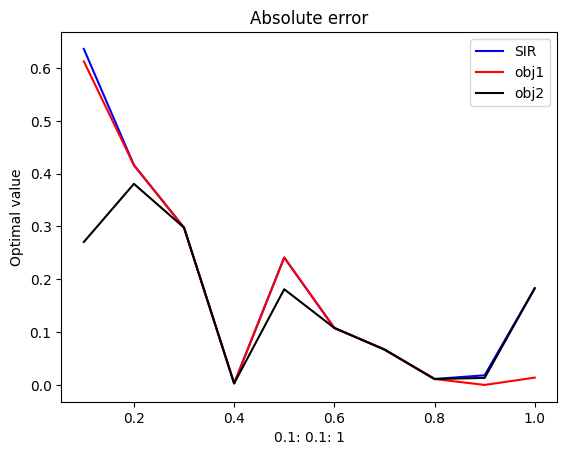

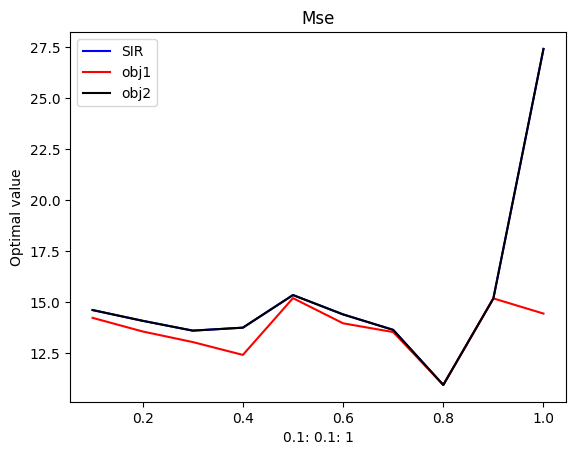

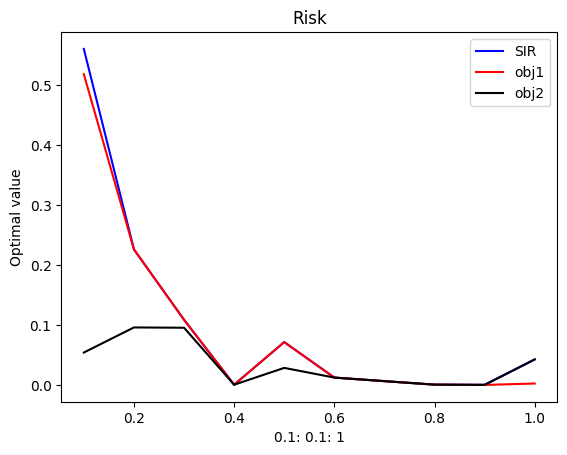

<Figure size 640x480 with 0 Axes>

In [134]:
sir_values = [[], [], []]
obj1_optimal_values = [[], [], []]
obj2_optimal_values = [[], [], []]
obj1_optimal_Q = [[],[],[]]
obj2_optimal_Q = [[],[],[]]

# Graphs
import matplotlib.pyplot as plt
def plotyy(x, li1, li2, li3,label1 ,label2 ,label3, title, xlabel, ylabel):
    # plt.plot(x, obj1_optimal_values, label= label_variable, color='blue', marker='o')
    plt.plot(x, li1, label = label1, color='blue')
    plt.plot(x, li2, label = label2, color='red')
    plt.plot(x, li3, label = label3, color='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    # plt.grid(True)
    
ar_coeff = [0.98, 0.95, 0.98, 0.95];a1=2; a2=3; initial_value = 0; n_gene = 10000; n_obs = 1000; H = 50; S=10; n_rep = 1
x = np.arange(0.1, 1.1, 0.1)
# values at optimal Q 
for i in range(len(x)):
    SIR_values, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q = Test1([x[i], 0.95, 0.98, 0.95], a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)
    for j in range(3):
        sir_values[j].append(SIR_values[j])
        obj1_optimal_values[j].append(Obj1_optimal_values[j])
        obj2_optimal_values[j].append(Obj2_optimal_values[j])
        obj1_optimal_Q[j].append(Obj1_optimal_Q[j])
        obj2_optimal_Q[j].append(Obj2_optimal_Q[j])
        if j == 1:
            sir_values[j] = [np.array([arr.squeeze()]) for arr in sir_values[j]]
            obj1_optimal_values[j] = [np.array([arr.squeeze()]) for arr in obj1_optimal_values[j]]
            obj2_optimal_values[j] = [np.array([arr.squeeze()]) for arr in obj2_optimal_values[j]]
        if j == 2:
            sir_values[j] = [np.array([arr.squeeze()]) for arr in sir_values[j]]
            obj1_optimal_values[j] = [np.array([arr.squeeze()]) for arr in obj1_optimal_values[j]]
            obj2_optimal_values[j] = [np.array([arr.squeeze()]) for arr in obj2_optimal_values[j]]

for j in range(3):
    if j ==0:
        plotyy(x, sir_values[j], obj1_optimal_values[j], obj2_optimal_values[j],'SIR', 'obj1','obj2' ,'Absolute error' , '0.1: 0.1: 1', 'Optimal value')
        plt.figure()
    if j ==1:
        plotyy(x, sir_values[j], obj1_optimal_values[j], obj2_optimal_values[j], 'SIR', 'obj1','obj2' ,'Mse' , '0.1: 0.1: 1', 'Optimal value')
        plt.figure()
    if j ==2:
        plotyy(x, sir_values[j], obj1_optimal_values[j], obj2_optimal_values[j], 'SIR', 'obj1','obj2' ,'Risk' , '0.1: 0.1: 1', 'Optimal value')
        plt.figure()

plt.show()
# optimal Q 

### initial_value = 0

In [9]:
ar_coeff = [0.98, 0.95, 0.98, 0.95];a1=2; a2=3; initial_value = 0; n_gene = 10000; n_obs = 1000; H = 50; S=10; n_rep = 1
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 0.063737 & 0.007819 & 15.7034 \\ \hline
 1 & 0.051072 & 0.004022 & 15.4668 \\ \hline
 2 & 0.030671 & 0.001566 & 15.2281 \\ \hline
 3 & 0.005505 & 0.00031  & 15.0724 \\ \hline
 4 & 0.017409 & 0.000511 & 15.0532 \\ \hline
 5 & 0.039331 & 0.001866 & 15.1253 \\ \hline
 6 & 0.061466 & 0.004382 & 15.292  \\ \hline
 7 & 0.082359 & 0.007888 & 15.5365 \\ \hline
 8 & 0.102547 & 0.012195 & 15.8407 \\ \hline
 9 & 0.122221 & 0.017067 & 16.1858 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 & 0.063737 & 0.007819 & 15.7034 \\ \hline
 1 & 0.072777 & 0.007321 & 15.84   \\ \hline
 2 & 0.072549 & 0.006458 & 15.8305 \\ \hline
 3 & 0.066269 & 0.004984 & 15.7205 \\ \hline
 4 & 0.062124 & 0.004132 & 15.6699 \\ \hline
 5 & 0.059082 & 0.003839 & 15.6491 \\ \hline
 6 & 0.054965 & 0.004091 & 15.6496 \\ \hline
 7 & 0.052557 & 0.005914 & 15.7407 \\ \hline
 8 & 0.050247 & 0.00955  & 15.9059 \\ \hline
 9 & 0.047662 & 0.014105 & 16.0965 \\ \hli

(array([0.06373692]), 0.007819216653461438, 15.703433359062874)

In [102]:
ar_coeff = [0.98, 0.95, 0.98, 0.95];a1=2; a2=3; initial_value = 0; n_gene = 10000; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 0.015427 & 0.000285 & 14.1482 \\ \hline
 1 & 0.01542  & 0.000257 & 14.1499 \\ \hline
 2 & 0.028326 & 0.00078  & 14.1529 \\ \hline
 3 & 0.043639 & 0.001795 & 14.1957 \\ \hline
 4 & 0.059516 & 0.003275 & 14.2824 \\ \hline
 5 & 0.075298 & 0.005159 & 14.4081 \\ \hline
 6 & 0.090737 & 0.007381 & 14.5664 \\ \hline
 7 & 0.105707 & 0.009874 & 14.7506 \\ \hline
 8 & 0.120138 & 0.012578 & 14.9547 \\ \hline
 9 & 0.133994 & 0.015439 & 15.1732 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 & 0.015427 & 0.000285 & 14.1482 \\ \hline
 1 & 0.005572 & 6.2e-05  & 14.2162 \\ \hline
 2 & 0.012467 & 0.000184 & 14.26   \\ \hline
 3 & 0.01596  & 0.000298 & 14.2877 \\ \hline
 4 & 0.018044 & 0.000406 & 14.3081 \\ \hline
 5 & 0.019479 & 0.000519 & 14.3258 \\ \hline
 6 & 0.020664 & 0.000648 & 14.343  \\ \hline
 7 & 0.021658 & 0.000796 & 14.3605 \\ \hline
 8 & 0.022502 & 0.000965 & 14.3789 \\ \hline
 9 & 0.023325 & 0.00116  & 14.3987 \\ \hli

In [106]:
ar_coeff = [0.1, 0.1, 0.1, 0.1];a1=2; a2=3; initial_value = 0; n_gene = 10000; n_obs = 30000; H = 50; S=10; n_rep = 1
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 0.047579 & 0.015998 & 14.2875 \\ \hline
 1 & 0.023796 & 0.003791 & 14.2885 \\ \hline
 2 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 3 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 4 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 5 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 6 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 7 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 8 & 0.023787 & 0.00379  & 14.2885 \\ \hline
 9 & 0.023787 & 0.00379  & 14.2885 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 & 0.047579 & 0.015998 & 14.2875 \\ \hline
 1 & 0.023146 & 0.003915 & 14.2885 \\ \hline
 2 & 0.030691 & 0.002885 & 14.2907 \\ \hline
 3 & 0.496579 & 0.166369 & 14.3032 \\ \hline
 4 & 0.952838 & 0.477661 & 14.3182 \\ \hline
 5 & 0.418585 & 0.324955 & 14.3131 \\ \hline
 6 & 0.220016 & 0.190906 & 14.2995 \\ \hline
 7 & 0.340626 & 0.407956 & 14.3208 \\ \hline
 8 & 0.744318 & 0.484856 & 14.3284 \\ \hline
 9 & 1.44856  & 0.635388 & 14.3395 \\ \hli

## before burn-off initial_value = 50

In [167]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; initial_value = 50; n_gene = 10000; n_obs = 100; H = 5; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 1.70897 & 1.08398  & 138.089 \\ \hline
 1 & 1.13555 & 0.601638 & 138.082 \\ \hline
 2 & 1.11952 & 0.599421 & 138.083 \\ \hline
 3 & 1.11926 & 0.599328 & 138.083 \\ \hline
 4 & 1.1192  & 0.599321 & 138.083 \\ \hline
 5 & 1.1192  & 0.59932  & 138.083 \\ \hline
 6 & 1.1192  & 0.59932  & 138.083 \\ \hline
 7 & 1.1192  & 0.59932  & 138.083 \\ \hline
 8 & 1.1192  & 0.59932  & 138.083 \\ \hline
 9 & 1.1192  & 0.59932  & 138.083 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 &   1.70897 & 1.08398  & 138.089 \\ \hline
 1 &   5.01339 & 0.662286 & 138.569 \\ \hline
 2 &   4.5122  & 0.865677 & 138.892 \\ \hline
 3 &   5.73667 & 0.999739 & 139.001 \\ \hline
 4 &  12.968   & 1.1026   & 139.011 \\ \hline
 5 &   9.28889 & 1.19216  & 139.097 \\ \hline
 6 &   9.32489 & 1.25928  & 139.22  \\ \hline
 7 &   9.38785 & 1.29984  & 139.293 \\ \hline
 8 & 111.881   & 1.35067  & 139.323 \\ \hline
 9 &  47.7381  & 1.38511  & 139.267 \\ \hli

In [168]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; initial_value = 50; n_gene = 10000; n_obs = 150; H = 5; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 1.081    & 0.786352 & 14.5911 \\ \hline
 1 & 0.555671 & 0.324748 & 14.5534 \\ \hline
 2 & 0.603777 & 0.323612 & 14.5536 \\ \hline
 3 & 0.601722 & 0.323585 & 14.5536 \\ \hline
 4 & 0.601858 & 0.323583 & 14.5536 \\ \hline
 5 & 0.601859 & 0.323582 & 14.5536 \\ \hline
 6 & 0.601859 & 0.323582 & 14.5536 \\ \hline
 7 & 0.601859 & 0.323582 & 14.5536 \\ \hline
 8 & 0.601859 & 0.323582 & 14.5536 \\ \hline
 9 & 0.601859 & 0.323582 & 14.5536 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 &  1.081   & 0.786352 & 14.5911 \\ \hline
 1 &  1.98115 & 0.491703 & 14.7734 \\ \hline
 2 & 21.6004  & 0.673369 & 14.9457 \\ \hline
 3 &  9.56145 & 0.79719  & 15.0812 \\ \hline
 4 &  8.20063 & 0.921964 & 15.1835 \\ \hline
 5 &  5.58788 & 0.992343 & 15.2243 \\ \hline
 6 &  6.87476 & 1.07931  & 15.2835 \\ \hline
 7 &  6.73267 & 1.14186  & 15.2721 \\ \hline
 8 &  6.81184 & 1.1965   & 15.3419 \\ \hline
 9 &  6.80978 & 1.23423  & 15.3519 \\ \hli

In [169]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; initial_value = 50; n_gene = 10000; n_obs = 200; H = 5; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 0.761693 & 0.664711 & 14.3506 \\ \hline
 1 & 0.265947 & 0.228487 & 14.2973 \\ \hline
 2 & 0.26608  & 0.22785  & 14.2974 \\ \hline
 3 & 0.266094 & 0.227839 & 14.2974 \\ \hline
 4 & 0.266096 & 0.227838 & 14.2974 \\ \hline
 5 & 0.266096 & 0.227838 & 14.2974 \\ \hline
 6 & 0.266096 & 0.227838 & 14.2974 \\ \hline
 7 & 0.266096 & 0.227838 & 14.2974 \\ \hline
 8 & 0.266096 & 0.227838 & 14.2974 \\ \hline
 9 & 0.266096 & 0.227838 & 14.2974 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 &  0.761693 & 0.664711 & 14.3506 \\ \hline
 1 &  2.08204  & 0.391811 & 14.4652 \\ \hline
 2 & 21.0806   & 0.576346 & 14.641  \\ \hline
 3 &  3.28306  & 0.741726 & 14.7424 \\ \hline
 4 &  2.49677  & 0.868457 & 14.8676 \\ \hline
 5 &  2.56897  & 0.953568 & 14.8759 \\ \hline
 6 &  2.56557  & 1.00767  & 14.8951 \\ \hline
 7 &  2.53386  & 1.06863  & 14.9026 \\ \hline
 8 &  2.54515  & 1.12604  & 14.956  \\ \hline
 9 &  2.54856  & 1.17423  & 15.00

In [170]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; initial_value = 50; n_gene = 10000; n_obs = 250; H = 5; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 0.477931 & 0.517813 & 13.9433 \\ \hline
 1 & 0.244031 & 0.180241 & 13.9204 \\ \hline
 2 & 0.244588 & 0.18004  & 13.9206 \\ \hline
 3 & 0.244615 & 0.180042 & 13.9206 \\ \hline
 4 & 0.244618 & 0.180042 & 13.9206 \\ \hline
 5 & 0.244618 & 0.180042 & 13.9206 \\ \hline
 6 & 0.244618 & 0.180042 & 13.9206 \\ \hline
 7 & 0.244618 & 0.180042 & 13.9206 \\ \hline
 8 & 0.244618 & 0.180042 & 13.9206 \\ \hline
 9 & 0.244618 & 0.180042 & 13.9206 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 & 0.477931 & 0.517813 & 13.9433 \\ \hline
 1 & 1.46208  & 0.314307 & 14.0427 \\ \hline
 2 & 8.60586  & 0.505533 & 14.1955 \\ \hline
 3 & 2.568    & 0.668739 & 14.2852 \\ \hline
 4 & 2.52945  & 0.785723 & 14.352  \\ \hline
 5 & 3.84721  & 0.877173 & 14.4108 \\ \hline
 6 & 2.96899  & 0.92662  & 14.4451 \\ \hline
 7 & 2.99279  & 1.00802  & 14.4898 \\ \hline
 8 & 2.99064  & 1.07435  & 14.5228 \\ \hline
 9 & 2.99087  & 1.10878  & 14.5448 \\ \hli

In [172]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; initial_value = 50; n_gene = 10000; n_obs = 10000; H = 50; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrr}
\hline
 0 & 0.218124 & 0.064605 & 15.2272 \\ \hline
 1 & 0.221122 & 0.058916 & 15.2279 \\ \hline
 2 & 0.222141 & 0.059462 & 15.2279 \\ \hline
 3 & 0.222161 & 0.059473 & 15.2279 \\ \hline
 4 & 0.222162 & 0.059474 & 15.2279 \\ \hline
 5 & 0.222163 & 0.059474 & 15.2279 \\ \hline
 6 & 0.222163 & 0.059474 & 15.2279 \\ \hline
 7 & 0.222163 & 0.059474 & 15.2279 \\ \hline
 8 & 0.222163 & 0.059474 & 15.2279 \\ \hline
 9 & 0.222163 & 0.059474 & 15.2279 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrr}
\hline
 0 & 0.218124 & 0.064605 & 15.2272 \\ \hline
 1 & 0.030162 & 0.003031 & 15.2626 \\ \hline
 2 & 0.111483 & 0.038151 & 15.3011 \\ \hline
 3 & 0.140921 & 0.220259 & 15.3952 \\ \hline
 4 & 0.162061 & 0.356587 & 15.4608 \\ \hline
 5 & 0.172721 & 0.449134 & 15.5069 \\ \hline
 6 & 0.178294 & 0.538836 & 15.5524 \\ \hline
 7 & 0.180988 & 0.593887 & 15.5783 \\ \hline
 8 & 0.1825   & 0.649617 & 15.6073 \\ \hline
 9 & 0.183255 & 0.70857  & 15.635  \\ \hli

In [19]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.31385399163529293, 0.20888934985692542, 0.21857548017724912, 0.24356757361807926, 0.2526551411466693, 0.26480564264925466, 0.26811956405491655, 0.2707924321112855, 0.27299396087774935, 0.2745857013649551]
error_2: [0.31385399163529293, 0.6860876287830372, 0.9295948082630341, 0.8219493524033881, 1.2328661277972486, 1.6437914620634768, 1.8485461856624332, 1.7759219023688528, 1.769190799937108, 1.7710303469530009]
proj_error_1: [0.35556987619845537, 0.3236003188565484, 0.33316372232246083, 0.3538154366722954, 0.37024474379077255, 0.38415229652164024, 0.38954826605815496, 0.39281107979178437, 0.3948142165442139, 0.39609680704655487]
proj_error_2: [0.35556987619845537, 0.5406303819332359, 0.7222701336715522, 0.8706556081556747, 0.9230840235032839, 0.9620541952110099, 0.9822871107293849, 1.0174255004783384, 1.0442399968496756, 1.05327191391599]


In [20]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs =1000; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.023031512647457942, 0.05082917781474348, 0.08767997432025831, 0.1142947575621052, 0.13302138751844808, 0.14598719845973698, 0.15480761758378073, 0.16079940714256735, 0.16479964762286617, 0.16747349055294133]
error_2: [0.023031512647457942, 0.027099367028705378, 0.037709587038740146, 0.05253731201357412, 0.06977975742771295, 0.08361968363995466, 0.09318371834129273, 0.09716553339355183, 0.10253229666863746, 0.10531549698217618]
proj_error_1: [0.05284408209495237, 0.07142805250129253, 0.1036326158322229, 0.12968987324424694, 0.14880692321079744, 0.16243891311787131, 0.1718566873013109, 0.1783179032028999, 0.18265844070162274, 0.18556501214793836]
proj_error_2: [0.05284408209495237, 0.07868401811836988, 0.1398321282504317, 0.24088050086432236, 0.3691098542212153, 0.5076602763526714, 0.6086867003732731, 0.6836657165567046, 0.713218442362346, 0.7168008938263134]


In [21]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs =1000; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.018708286605392657, 0.019195113954952478, 0.019204751907439956, 0.019205617117122636, 0.01920566167107236, 0.01920566356929005, 0.01920566328021754, 0.019205663126661218, 0.019205662988210206, 0.019205662959445247]
error_2: [0.018708286605392657, 0.10201385727431171, 0.5114324569486037, 1.8842789052094258, 27.567462857042823, 6.320695231105325, 6.14623123990184, 5.094505330343536, 5.586688725293994, 6.3641894227617835]
proj_error_1: [0.029033497763111312, 0.02965324073619432, 0.029681942955166022, 0.029688600807455886, 0.02969060072158298, 0.029691978514554775, 0.02969275564527118, 0.02969321660433482, 0.029693553046899957, 0.029693775630100824]
proj_error_2: [0.029033497763111312, 0.11764228077021477, 0.3515868547245, 0.5468374125362984, 0.6898397631601425, 0.7853495384778012, 0.8466767077562019, 0.8930500369257952, 0.9332932632198194, 0.9590608234046174]


In [23]:
ar_coeff = [0.98, 0.95, 0.5, 0.8];a1=2; a2=3; n_obs =50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.33668433920295276, 0.4151245381196829, 0.45700104801072317, 2.0801327025174574, 0.6505880960783378, 0.7330085059559812, 0.7627764626035329, 0.9398082816271899, 1.327246608605975, 1.9350992206519728]
error_2: [0.33668433920295276, 2.4454389047796887, 0.5494934626316866, 0.6492725637827286, 0.96515630092041, 0.8050397014899113, 1.8745812711166039, 1.6448835783212996, 1.3663437246666126, 1.323922472364423]
proj_error_1: [0.4874792900498152, 0.40592307505931297, 0.3949777930389432, 0.40801800349256323, 0.4300367708311122, 0.4527651889786792, 0.4852164142543511, 0.5090484504591276, 0.5305887141259358, 0.5405974911280311]
proj_error_2: [0.4874792900498152, 0.6607693343809968, 0.8101015161002184, 0.8988792537015666, 1.0057605245916683, 1.0559097670780273, 1.1175691484273813, 1.1379078169731862, 1.1569198236838896, 1.1643289395803338]


In [24]:
ar_coeff = [0.98, 0.95, 0.5, 0.8];a1=2; a2=3; n_obs =1000; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.02577708268414008, 0.0320879529096818, 0.04598976166041603, 0.06203089401878037, 0.07910442127403178, 0.09564733363959953, 0.11173816387095631, 0.12741448945991193, 0.14235778940177826, 0.15677200591770246]
error_2: [0.02577708268414008, 0.026825385760540398, 0.02893846630459992, 0.03222590201394618, 0.03504490033299692, 0.037932322540569635, 0.040150989573603836, 0.04205000271357626, 0.04313763074890877, 0.043693178926649895]
proj_error_1: [0.08556500471744315, 0.077390148848606, 0.08005211139627445, 0.08765622532638305, 0.0974571353890166, 0.10833365904803902, 0.11957229671198161, 0.1307327088069471, 0.14164950030285373, 0.1521611140977529]
proj_error_2: [0.08556500471744315, 0.11713567513506579, 0.18277097584180083, 0.29138038141834427, 0.42703147700596233, 0.5498905962819259, 0.6441109353689477, 0.7135909516313048, 0.7770572581327982, 0.8321327269921072]


In [25]:
ar_coeff = [0.98, 0.95, 0.5, 0.8];a1=2; a2=3; n_obs =100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.21783081237913515, 0.22183624142490843, 0.44013658505463665, 0.21634143532042646, 0.21811427767484404, 0.23588188541884064, 0.25699766476664154, 0.2849900551409874, 0.31864500450800376, 0.3581100362016176]
error_2: [0.21783081237913515, 0.22933680267943207, 0.3035539072110559, 0.8546335556738107, 4.026922901278503, 2.166935627714631, 3.620159772845338, 1.827477522615302, 1.3724005984318026, 1.2375537174722653]
proj_error_1: [0.3669422756452279, 0.29744034787307283, 0.2741320846041592, 0.2713323181846321, 0.2739568005716647, 0.2822800711379712, 0.28760995287878577, 0.2968982751055871, 0.3090349636505114, 0.3215017258159728]
proj_error_2: [0.3669422756452279, 0.4516298459281676, 0.6368293534224257, 0.764901307131975, 0.8634781588008787, 0.9520826234247975, 1.0055780290786274, 1.0233567963836052, 1.0380120318611865, 1.0513273189167356]


In [26]:
ar_coeff = [0.98, 0.95, 0.5, 0.8];a1=2; a2=3; n_obs =50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.7405584865666383, 0.6339587100187647, 1.286406075967169, 0.6893170230718789, 0.7618893863077747, 1.1779389043057573, 8.178240446343189, 1.920028144571977, 3.561576528387398, 3.880113739719338]
error_2: [0.7405584865666383, 1.5976286717967063, 1.0495370043350687, 1.1005637940368984, 1.1510197082030762, 1.3451438845588575, 1.3802647442978542, 1.4712914721600827, 1.5144781512294117, 1.5897378517229481]
proj_error_1: [0.5863939629364511, 0.4918758915972588, 0.469613903861341, 0.4815660195627222, 0.4993937152218075, 0.513094813830316, 0.5412192828590493, 0.5573776992498239, 0.5804563180007548, 0.5966383309020008]
proj_error_2: [0.5863939629364511, 0.6917382564629608, 0.8574391876411726, 0.9428863089202203, 1.0256823231208871, 1.073490086915242, 1.1051425057531714, 1.1373701529251203, 1.1582530508912299, 1.171382500266029]


In [27]:
ar_coeff = [0.98, 0.95, 0.5, 0.8];a1=2; a2=3; n_obs =1000; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.03184250589012571, 0.033461301071176584, 0.04003965038259654, 0.05160866222501442, 0.06577493242660659, 0.08037435682292716, 0.0949197531055858, 0.10885256033932811, 0.12219580414564948, 0.13510690825046423]
error_2: [0.03184250589012571, 0.032070044730169986, 0.03297196494517969, 0.0347698371562625, 0.036476551348033126, 0.03775274498089051, 0.03907655174883356, 0.039998212358039, 0.04047255795938892, 0.0406851914956071]
proj_error_1: [0.09116854100060671, 0.08137538260569935, 0.08002875498717421, 0.08388587088495777, 0.09050272430502435, 0.09883487810204489, 0.10795161170306417, 0.11730355871360588, 0.12655122954755693, 0.13558099949342572]
proj_error_2: [0.09116854100060671, 0.12401503416296267, 0.1961120230396143, 0.3018068381493984, 0.4336084148609618, 0.5613860650534638, 0.6705552834530841, 0.7659054753531891, 0.8399353790589976, 0.8965423057717676]


In [7]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.2597079713764446, 0.297383281242408, 0.3484010387549731, 0.3325439942648361, 0.3698202514467658, 0.4490708423324541, 0.5450104037384408, 0.5276583675466174, 0.4960906318721108, 0.49246700998608256]
error_2: [0.2597079713764446, 1.261443598626526, 0.6525276543606882, 0.8416694932821351, 1.142068526761529, 2.2402018226159743, 1.6328660552122094, 3.3596915945404926, 3.4786209021048804, 2.7804959267717386]
proj_error_1: [0.3768996093646178, 0.3453907882478051, 0.3449233302910275, 0.36238500498861353, 0.37308113447779695, 0.3792489382896697, 0.381570034544971, 0.3825648268792168, 0.38506332383061165, 0.3861685026491564]
proj_error_2: [0.3768996093646178, 0.5536928436329329, 0.7063229604790529, 0.8182570700326177, 0.90959487533295, 0.9845726051191797, 0.9984275825325492, 1.0331343484424873, 1.057990418918791, 1.0638425286454802]


In [8]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.09117496288590834, 0.09099531485531784, 0.09102744424369252, 0.09117043812394515, 0.09127532620122736, 0.09138197970945841, 0.09143642533102614, 0.09147202901656487, 0.09149149277911944, 0.09150402365668352]
error_2: [0.09117496288590834, 36.235874846838534, 9.89725628991918, 11.354309406120802, 22.965271282666976, 10.863470886410955, 10.156600962428024, 14.948913700850554, 10.881523583585988, 12.840718775674906]
proj_error_1: [0.15189393124643488, 0.15797439852206138, 0.16092461389322638, 0.16295873787321075, 0.16435849519118123, 0.16552504519223293, 0.1662283158667911, 0.16663794424327222, 0.16688924693318696, 0.16703416338724203]
proj_error_2: [0.15189393124643488, 0.7381566616783095, 0.8050120955555012, 0.8944262464001617, 0.9595516161423479, 1.0191396970489996, 1.0423431399558758, 1.062535357595913, 1.0804525128630842, 1.091104365285025]


In [11]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.054265822725222866, 0.05545565201638189, 0.05551282940228518, 0.055513382270399, 0.05551346763597479, 0.05551337539844617, 0.05551311751100389, 0.05551305738782629, 0.05551302917416386, 0.05551300078639691]
error_2: [0.054265822725222866, 6.925894404256326, 3.588186551410534, 5.8058244029253965, 9.063469522630772, 10.2625276297396, 9.38740239892281, 18.452144677937355, 100.29202052765862, 26.25203051552758]
proj_error_1: [0.090002526695807, 0.09284325777442592, 0.09330205343468606, 0.09353506926480769, 0.09366262711688154, 0.09375565273581127, 0.0938013348132648, 0.09383060545704121, 0.09385018111701351, 0.09386260430408448]
proj_error_2: [0.090002526695807, 0.564585163786363, 0.6895680860314037, 0.8000288980073573, 0.8858767421067776, 0.9359376544184602, 0.9846712036655948, 1.0209868272522769, 1.0405116002405337, 1.0581188312728975]


In [12]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 200
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.20716279630632597, 0.4778154980595246, 0.21369689786565504, 0.24716451648005766, 0.3010613307874673, 3.0543414405960867, 2.040068411477788, 0.7419072271299991, 0.6710341631993078, 0.6847169336435814]
error_2: [0.20716279630632597, 0.6725516027599722, 1.0481800094666438, 4.667647586608393, 1.3461724753176176, 4.9614732433831925, 3.1852671536282946, 5.371154054584539, 4.592569646853457, 3.786831860336913]
proj_error_1: [0.31499143029829324, 0.28953754090706263, 0.29979023668567684, 0.3092001258636976, 0.31671994198570497, 0.319968237564217, 0.3252591803501303, 0.3297304204631022, 0.3323666731006208, 0.3344489820237571]
proj_error_2: [0.31499143029829324, 0.542259040637527, 0.7104026703718053, 0.8282452251514875, 0.9029118530341806, 0.9478525267179617, 0.9934312537163877, 1.028210744206961, 1.059872914457423, 1.0939051002889988]


In [9]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.0030319708551065426, 0.003796172013200908, 0.0038229906802230416, 0.0038243785640760097, 0.003824494872576213, 0.0038245050319453324, 0.003824506010581674, 0.0038245061099327683, 0.003824506126428795, 0.0038245061334689456]
error_2: [0.0030319708551065426, 0.02519812884152465, 0.13409699379522885, 0.4203366279995235, 1.102048643487441, 1.754685750387789, 1.9843202955230836, 2.5613964452320332, 3.0878947453422647, 3.6472004096576853]
proj_error_1: [0.005299582455634599, 0.006007477557706655, 0.006037927179647955, 0.006040281095703004, 0.0060408111713225795, 0.0060411396853517286, 0.00604133522345865, 0.006041460158304869, 0.006041542863952805, 0.006041596657237805]
proj_error_2: [0.005299582455634599, 0.029482882946371965, 0.12584871485100266, 0.3036524642105514, 0.48974651554617915, 0.6304851956372349, 0.7298279282415753, 0.8027205681865438, 0.861443063628813, 0.9034427354873154]


In [3]:
ar_coeff = [0.9, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.0017318868228022798, 0.0025485968669179703, 0.0042431417747498265, 0.005898689742667566, 0.007320132993337807, 0.008480997330751791, 0.009339822404578518, 0.009979298112933535, 0.010443809032906884, 0.01079302401280742]
error_2: [0.0017318868228022798, 0.003011673719673007, 0.0058067639762267465, 0.009012447157538725, 0.0122819161718582, 0.015221846866847927, 0.017499568504897086, 0.019212100984844542, 0.020519866133926867, 0.021499802160391962]
proj_error_1: [0.004892401346558104, 0.006706018047616773, 0.008961395472848433, 0.010875417172219579, 0.012395186808976279, 0.013537371223056087, 0.014380540337677949, 0.015006541382273388, 0.01545574845955221, 0.0157899792992878]
proj_error_2: [0.004892401346558104, 0.014480061199817073, 0.0343209914881714, 0.0691959468578817, 0.13008466133865912, 0.2184846514027684, 0.32258423038398254, 0.420292394382683, 0.5139564419640742, 0.5951189378016163]


In [16]:
ar_coeff = [0.9, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 200
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.002027941569410852, 0.002949790664465456, 0.004575202409123697, 0.006103591252780103, 0.007365696138832848, 0.008413561912012637, 0.009252659014607797, 0.009896061578655158, 0.0103882793932453, 0.010753858904787337]
error_2: [0.002027941569410852, 0.0034378521962034198, 0.0060766141168998224, 0.009012187997558601, 0.011952371630558525, 0.01461003733826553, 0.016808094958092643, 0.018512068430644128, 0.019695228326714068, 0.02056469955424515]
proj_error_1: [0.005359475853873043, 0.006593097765889583, 0.008692720969036337, 0.01047667737052602, 0.011880431163113526, 0.012976741354696461, 0.013818798973587924, 0.014449699906349494, 0.014918160728052519, 0.015257000465306243]
proj_error_2: [0.005359475853873043, 0.013548621733385016, 0.03389819486800672, 0.07193710392796064, 0.13596305830867617, 0.22894808394706329, 0.34012477253864953, 0.4489956944372001, 0.5453861345302703, 0.6290819291555363]


In [4]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.003447792028558291, 0.05067483312349222, 0.08905680736513925, 0.1161881016220394, 0.13520554321032363, 0.1484260401767266, 0.15755884133140713, 0.16383620122807888, 0.16811469828537987, 0.17101103966412073]
error_2: [0.003447792028558291, 0.005028889713353222, 0.008968507736913683, 0.014357907125048294, 0.020727005852597166, 0.02776521521985921, 0.03432937957399351, 0.040432660508520374, 0.04466863876452158, 0.04729710154530367]
proj_error_1: [0.005830028286613875, 0.051121020601353415, 0.09106012356645557, 0.12009258738625313, 0.1408186460892618, 0.15540319008868747, 0.1655626352873023, 0.1725847208063865, 0.1773886255179747, 0.18064834899820734]
proj_error_2: [0.005830028286613875, 0.014025473652442166, 0.03422157376751689, 0.07117050774766617, 0.1273970915734497, 0.21053654460191282, 0.3174287356919544, 0.4290427321193142, 0.5027967625564279, 0.5689101843498636]


In [5]:
ar_coeff = [0.9, 0.8, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.0026207915703608795, 0.05209659464067995, 0.09455791078424113, 0.12609318779024778, 0.1486614009476377, 0.16442196418926824, 0.17523111719939005, 0.1825425552894016, 0.1874527781873938, 0.19073937019632922]
error_2: [0.0026207915703608795, 0.004511465735974079, 0.007386144229137445, 0.011217849010376413, 0.015794090512910395, 0.020695770544478572, 0.025048070467288387, 0.028305387775243426, 0.030482818643878293, 0.03155996988600509]
proj_error_1: [0.005500795677336801, 0.05017414373008629, 0.08883647544833168, 0.11653699894268582, 0.1358233410805941, 0.1490242125980116, 0.15794935906664567, 0.16392597197759876, 0.1679116973083103, 0.17056653840964958]
proj_error_2: [0.005500795677336801, 0.01544677738336817, 0.033108447573428984, 0.06128687918000923, 0.10799788156242031, 0.1864442953356103, 0.28396203213786303, 0.3821939613227976, 0.49265654884755555, 0.5813081562413529]


In [75]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.26631355657701344, 20.019847417338834, 0.2390510712527715, 0.3117658071366889, 0.4042656054416578, 0.25147861586475523, 0.25770888430545624, 0.26461626883074824, 0.2702026451620006, 0.2744890930601052]
error_2: [0.26631355657701344, 0.6096732451075679, 0.6974712969992278, 1.1488183782674097, 2.0212975056375577, 2.3740583794425176, 2.032727228946393, 15.24978396022997, 2.9845191100596837, 2.911607412682122]
proj_error_1: [0.3075288701393834, 0.2953578276936392, 0.30659251904132395, 0.32565427543332737, 0.34302437984564016, 0.3546721075082486, 0.36385288443875424, 0.36948205952906643, 0.373788749166327, 0.3770233282578541]
proj_error_2: [0.3075288701393834, 0.5387665027345545, 0.6983538199946301, 0.8088726501860176, 0.8859499653784213, 0.9490691352483269, 0.9769339581531722, 1.0069839985300941, 1.0352277372363623, 1.0598308545347819]


In [77]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [1.5336734109390813, 1.054208490164794, 0.5432404481627146, 0.5431990423188897, 0.6218420356479474, 0.6837142462307016, 0.6868253815697924, 0.7240947869507666, 0.6685711151362842, 0.6112587678129386]
error_2: [1.5336734109390813, 1.1990715011515234, 1.254079508433306, 1.517634979890706, 11.184969455183902, 1.9838258484654878, 1.808377879987101, 1.7032334343335456, 1.7612660647582792, 1.8115368432540941]
proj_error_1: [0.36343651978281505, 0.3325032143124389, 0.34174516520461096, 0.3563192978005832, 0.3689160157063241, 0.3788940752651094, 0.38660273373601944, 0.3915247652463472, 0.3947504585137228, 0.3965601033649374]
proj_error_2: [0.36343651978281505, 0.5402555828888707, 0.7311896631552469, 0.8469717446488358, 0.9270806402134384, 0.9942148403656027, 1.0197102011356385, 1.0570673135595632, 1.0904142165203767, 1.120208451688651]


In [76]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.03360550781403819, 0.06083470791090147, 0.0946031699539918, 0.12084149345692292, 0.1400350221615577, 0.15341742844843836, 0.1625946011275438, 0.16895158783158826, 0.17326481038388994, 0.17624741724687382]
error_2: [0.03360550781403819, 0.04210849449480535, 0.05763195613006898, 0.07628746827525404, 0.09897474865458518, 0.11888317282983075, 0.12823120410758745, 0.1296773869745803, 0.1305044488599505, 0.13251498119914068]
proj_error_1: [0.06938443596866699, 0.08726112543047908, 0.11615787153983728, 0.14113325715199962, 0.1604271181206625, 0.17444055844716683, 0.1842634793039805, 0.19112027064868284, 0.19578509772299502, 0.19902738042687118]
proj_error_2: [0.06938443596866699, 0.10610238507633708, 0.1854288424918018, 0.30441637329524285, 0.43822199097550274, 0.5595010518091894, 0.6346847288972898, 0.694988519875497, 0.7195562353478117, 0.7592095935093807]


In [71]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [11.996413760853972, 0.637285229431658, 2.825667509855269, 1.1420661851408505, 0.8384395683118985, 0.9707918684729606, 1.2294017541474096, 1.5079950317455277, 1.5429536108734498, 1.649909008301913]
error_2: [11.996413760853972, 1.4881542198431292, 0.8695086092750901, 1.5340373051969869, 1.4835188985241254, 1.600592593701808, 1.891228477209141, 1.9945751227627244, 2.11902269684859, 2.1476619259708616]
proj_error_1: [0.3487932041922701, 0.32516611974447557, 0.3345612688893668, 0.34824941144436317, 0.3566385222256106, 0.3649502112355965, 0.37133996581541157, 0.37668814064191997, 0.37997334094466195, 0.3821454746114173]
proj_error_2: [0.3487932041922701, 0.5897318104958398, 0.7530464030683228, 0.8650841323071262, 0.922198470619842, 1.0028437752778103, 1.0511580064732216, 1.0746750856056067, 1.068947012505103, 1.0818282452671846]


In [72]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 1
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.001642100510931943, 0.05138827308016913, 0.08906934246344611, 0.11566661940934542, 0.13431481417984648, 0.14708340713775014, 0.15578875155067995, 0.1616690992267883, 0.16576928374701272, 0.1686287864395224]
error_2: [0.001642100510931943, 0.0023610117883954285, 0.002599932174262909, 0.003119230842599352, 0.0034195503934204563, 0.004720302660284226, 0.004891990284791925, 0.003030928256523735, 0.0007446327856440726, 0.006991655949968645]
proj_error_1: [0.0037537731350579966, 0.05152938666409287, 0.09084360456242924, 0.11930099230776678, 0.13959270003921148, 0.15364937155137182, 0.16330533327531652, 0.16986141705048766, 0.1744489608912613, 0.17765528261286678]
proj_error_2: [0.0037537731350579966, 0.009139712386015192, 0.03874644190844947, 0.090794145697827, 0.1689091504615229, 0.2813993430446289, 0.40278010836256845, 0.5395759638971657, 0.679956846254055, 0.7907405728759608]


In [73]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.00313587408526395, 0.051509866646808, 0.08999531098027527, 0.1172548413515861, 0.13639410346690642, 0.149679765805397, 0.15883798985312803, 0.16512359578494984, 0.16941570496347785, 0.17234637289669374]
error_2: [0.00313587408526395, 0.005083463876083751, 0.008735356600751653, 0.013007304624527838, 0.01752497993172573, 0.02234314755630054, 0.02689661451232614, 0.030493022561365893, 0.03341420765750951, 0.0353630923112717]
proj_error_1: [0.005613257728476217, 0.051972365291687556, 0.09206519009219322, 0.12126978010996735, 0.14215606058411537, 0.15683284817482648, 0.16703179705165014, 0.17406795718967027, 0.1788886032804191, 0.18218806303312982]
proj_error_2: [0.005613257728476217, 0.014439223070991014, 0.03254964983579733, 0.06452839739942083, 0.12287120320988404, 0.21474509286309562, 0.3285096097845547, 0.44432798390720707, 0.5447811283706653, 0.6367614312334757]


In [74]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.0029694173514177168, 0.0037069837336749043, 0.0037349083657385175, 0.0037363560255661023, 0.0037364791598924318, 0.003736490232307035, 0.003736491228462837, 0.0037364913432950207, 0.0037364913627236985, 0.0037364913708203638]
error_2: [0.0029694173514177168, 0.029183741879443996, 0.25007989612063036, 2.06376747495639, 1.1362789578736952, 1.780065194711905, 2.650551989916408, 4.47057641232805, 3.873767685385781, 4.354849724384164]
proj_error_1: [0.005225089184021846, 0.005854570896976977, 0.00588003459018563, 0.005881631132109786, 0.0058821429970347915, 0.005882398827711759, 0.005882544554706347, 0.005882639609560154, 0.005882700961273564, 0.00588274048485857]
proj_error_2: [0.005225089184021846, 0.034288490522995055, 0.18780375844051092, 0.3990862108270521, 0.5820651108722497, 0.7015929117855652, 0.7824708777446117, 0.8409996126616034, 0.8866937715587272, 0.923655966273126]


In [68]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 1000; H = 50; S=10; n_rep = 10
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

error_1: [0.004955983833867983, 0.00725070852638926, 0.007459686148207345, 0.007480365079789641, 0.007482408744041491, 0.007482570126198784, 0.007482577805790702, 0.0074825752703251095, 0.007482573498713829, 0.0074825719105913735]
error_2: [0.004955983833867983, 0.12510405273083305, 0.6394301958774133, 1.2148512201868382, 2.033208888482941, 2.555999638248352, 3.4167545705926896, 4.0294325054657385, 4.736145409523196, 5.277044240248192]
proj_error_1: [0.012275650862933815, 0.013931155109581853, 0.01406358838850802, 0.01408716556273524, 0.014090051896248262, 0.014094461226933867, 0.014096968435353366, 0.01409854217670827, 0.01409949589590453, 0.014100117995916778]
proj_error_2: [0.012275650862933815, 0.12542897515830567, 0.45698239357895387, 0.6048867761516779, 0.7044931922007502, 0.8027271728815117, 0.8730775404982506, 0.9152135078803907, 0.9535891459441069, 0.982625121822637]


In [54]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

[0.32003561873838143, 0.3094876254211673, 0.28703373440892227, 0.2846272084696381, 0.2764521841763227, 0.3473650739559225, 0.3462922443765224, 0.3157456767811572, 0.31348714255285104, 0.310240624865276]
[0.32003561873838143, 2.893851822613672, 0.5926861657449937, 0.7048326943548928, 0.8016175129083013, 1.026833116227349, 1.2475469932356116, 1.5659860685780933, 1.7916904208432007, 2.0666446334622304]
[0.3595992392848013, 0.32571509115501157, 0.341227308450468, 0.3600135833681344, 0.36365617643814185, 0.36786736734173436, 0.3768467686481018, 0.38210834499513524, 0.3857780808054382, 0.3877070782580874]
[0.3595992392848013, 0.5473612445693271, 0.743316750228854, 0.8737421907845405, 0.9363213369555438, 0.9913142290028303, 1.0205851926373606, 1.0397418212203267, 1.0514511447811556, 1.067182048970556]


In [55]:
ar_coeff = [0.2, 0.4, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

[0.08367737978235025, 0.08174574349526319, 0.081603638424649, 0.08156521731005828, 0.08156102492260318, 0.08155361087376166, 0.08155609090287808, 0.08155866919308442, 0.08155919367482868, 0.08155869238149455]
[0.08367737978235025, 15.916270167562502, 35.994530337531366, 10.772052906580308, 17.178542851996696, 15.34129674712682, 37.872763702387545, 26.615663364739557, 27.875420471591546, 30.1816172450553]
[0.14565866996331012, 0.1504599376325952, 0.1530600193672295, 0.15416861526353903, 0.1548487139242746, 0.15532632416491857, 0.1556303029465924, 0.15583830533274837, 0.15598498841240313, 0.15608389868420158]
[0.14565866996331012, 0.7352104839785202, 0.8683355284611871, 0.9563740358166853, 1.0001011663675177, 1.0349555604511438, 1.0615255655789964, 1.078907236500349, 1.0919738147254483, 1.1020305018079755]


In [56]:
ar_coeff = [0.2, 0.4, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

[0.09969717010585404, 0.09971262209288562, 0.09987213459235661, 0.10010192479384875, 0.10026636716044195, 0.10053513416712612, 0.10068893860264348, 0.10073648610991799, 0.10080079030690178, 0.10094224953963454]
[0.09969717010585404, 3.8404544590326166, 5.01287437904552, 8.421892293626168, 16.82796292260045, 152.66412329636498, 16.19663790832562, 19.99417610827579, 27.301297621547274, 35.461134477457406]
[0.17126720464592093, 0.17955027306273746, 0.18365882998459881, 0.1863761583632422, 0.18850691025479294, 0.19088140917894858, 0.19219025483871513, 0.19260628088196483, 0.19307867323297767, 0.19402762396329043]
[0.17126720464592093, 0.7131770076375088, 0.8536454577041248, 0.9489900972705833, 1.0003306612272957, 1.03567264135467, 1.0580950327244847, 1.075377513564409, 1.08898830943876, 1.0990716937800504]


In [58]:
ar_coeff = [0.2, 0.4, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

[0.023829294998758258, 0.02535150106912397, 0.025480150211305678, 0.02549189117451231, 0.02549328246448699, 0.02549343868370414, 0.02549347545377436, 0.025493476207620866, 0.025493475454607433, 0.0254934744334566]
[0.023829294998758258, 0.26073830737478404, 0.6510815889080304, 1.8207555979271022, 3.741241863804159, 6.469165239154302, 5.315897865973586, 6.702003388550858, 7.8581777944037325, 9.33360552055226]
[0.0392275036936184, 0.041034209618014524, 0.04120885475690818, 0.04123357504348206, 0.041244878738140374, 0.04125056326890501, 0.04125377138480577, 0.04125587590296408, 0.0412571600303313, 0.04125795180759767]
[0.0392275036936184, 0.17097718937147297, 0.44810409078717556, 0.6472239276230628, 0.7787633308755759, 0.8663717180056496, 0.9233295141259231, 0.9619500374203136, 0.9920409655374253, 1.0150407602882647]


In [60]:
ar_coeff = [0.2, 0.4, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

[0.056117206331394436, 0.055771043187963935, 0.055771599468336444, 0.055774554678513485, 0.055776175702942174, 0.05577633032035781, 0.055776328840946944, 0.05577628740377724, 0.05577628568339661, 0.055776311540494485]
[0.056117206331394436, 610.95405191153, 10.56545623966917, 10.964309338141488, 23.86510667064466, 20.860355624442246, 47.447107313517975, 25.01860939427771, 23.874941892376523, 38.4304553660054]
[0.0950919259952914, 0.09765969172203923, 0.0983008464957276, 0.09856652098152294, 0.09871729967245031, 0.098809191541851, 0.09886522366644099, 0.09890041493192804, 0.09892245467316046, 0.0989370692662077]
[0.0950919259952914, 0.4970511269300997, 0.6604944630231196, 0.7938513099463065, 0.8877666977677054, 0.949140018786586, 0.9892863695356572, 1.0188617170172076, 1.040387152615843, 1.0569554449696954]


In [61]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

[0.08503993690398909, 0.08440180250239701, 0.10823609041117294, 0.13412962198397302, 0.1535787605656949, 0.1662657945080362, 0.17473608266078094, 0.18128759236483438, 0.18634700727706136, 0.1901516063336696]
[0.08503993690398909, 0.11130028582600758, 0.16741384271261756, 0.23109074382264733, 0.3167832262890067, 0.3782154887481313, 0.4699657860277871, 0.559466448792185, 0.5956289519685912, 0.6136403244152406]
[0.16617411004143315, 0.15916095149884135, 0.18146041932299498, 0.204825248940881, 0.2236225377257578, 0.23703245913933377, 0.24618537310991562, 0.25258530535662804, 0.25716974287394356, 0.2603989847737132]
[0.16617411004143315, 0.2842007739379931, 0.46327219293786925, 0.594824929849826, 0.7397499010504737, 0.81131900197724, 0.8710300962788051, 0.9087897777002933, 0.9439619699650951, 0.958223044735169]


In [ ]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 1000; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

In [367]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.563629 & 0.696984 & -0.036459 & -0.057586 & 0.142001 & 0.168168 & 0.257934 \\ \hline
 1 & 0.547318 & 0.736501 & -0.023771 & -0.060078 & 0.076466 & 0.122705 & 0.300401 \\ \hline
 2 & 0.526527 & 0.753352 & -0.018279 & -0.067872 & 0.032246 & 0.11221  & 0.360634 \\ \hline
 3 & 0.503897 & 0.760884 & -0.012372 & -0.067077 & 0.004415 & 0.105493 & 0.414772 \\ \hline
 4 & 0.487752 & 0.789972 & -0.002087 & -0.061196 & 0.049238 & 0.105269 & 0.483798 \\ \hline
 5 & 0.474254 & 0.794987 & -0.001071 & -0.058924 & 0.070112 & 0.114338 & 0.529523 \\ \hline
 6 & 0.464483 & 0.794495 & -0.001271 & -0.050684 & 0.08204  & 0.113911 & 0.547255 \\ \hline
 7 & 0.456227 & 0.777963 & -0.000786 & -0.043393 & 0.080229 & 0.106006 & 0.531278 \\ \hline
 8 & 0.449361 & 0.781378 & -0.001036 & -0.042482 & 0.091579 & 0.11464  & 0.560345 \\ \hline
 9 & 0.444394 & 0.803828 & -0.001607 & -0.044724 & 0.11382  & 0.135805 & 0.627692 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [440]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.548977 & 0.705698 & -0.012018 & -0.00642  & 0.111255 & 0.10554  & 0.058789 \\ \hline
 1 & 0.525603 & 0.738826 & -0.01248  & -0.010631 & 0.044737 & 0.049929 & 0.033372 \\ \hline
 2 & 0.503237 & 0.747901 & -0.007636 & -0.006237 & 0.0062   & 0.016609 & 0.024905 \\ \hline
 3 & 0.482257 & 0.75752  & -0.006056 & -0.000213 & 0.030041 & 0.031309 & 0.022969 \\ \hline
 4 & 0.466253 & 0.749844 & -0.006583 & -0.005233 & 0.044867 & 0.046812 & 0.027887 \\ \hline
 5 & 0.455189 & 0.76003  & -0.009017 & -0.005779 & 0.067757 & 0.070499 & 0.034117 \\ \hline
 6 & 0.446401 & 0.756107 & -0.00856  & -0.005571 & 0.076273 & 0.079011 & 0.037027 \\ \hline
 7 & 0.439151 & 0.759558 & -0.007926 & -0.005058 & 0.0885   & 0.091414 & 0.041763 \\ \hline
 8 & 0.433453 & 0.7624   & -0.00725  & -0.004048 & 0.098129 & 0.101263 & 0.045808 \\ \hline
 9 & 0.428659 & 0.761131 & -0.007722 & -0.003217 & 0.10348  & 0.106951 & 0.048203 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [441]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 800
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.549081 & 0.72087  & -0.008062 & -0.00358  & 0.095025 & 0.090005 & 0.2633   \\ \hline
 1 & 0.529082 & 0.749475 & -0.003857 & -0.001052 & 0.03927  & 0.03825  & 0.179391 \\ \hline
 2 & 0.506656 & 0.766978 & -0.003266 & -0.000408 & 0.006079 & 0.007827 & 0.132064 \\ \hline
 3 & 0.48714  & 0.77553  & -0.002067 &  0.004332 & 0.038529 & 0.039099 & 0.114497 \\ \hline
 4 & 0.472019 & 0.776947 & -0.00209  &  0.002658 & 0.059137 & 0.059703 & 0.104282 \\ \hline
 5 & 0.460998 & 0.785992 & -0.00048  &  0.006562 & 0.080149 & 0.081987 & 0.103256 \\ \hline
 6 & 0.451191 & 0.784643 &  0.001134 &  0.00325  & 0.09164  & 0.093633 & 0.100688 \\ \hline
 7 & 0.443549 & 0.781605 &  0.002141 &  0.003423 & 0.099181 & 0.101699 & 0.101674 \\ \hline
 8 & 0.437082 & 0.780774 &  0.002423 &  0.003419 & 0.10686  & 0.109918 & 0.103005 \\ \hline
 9 & 0.431966 & 0.781111 &  0.00247  &  0.003773 & 0.113652 & 0.117247 & 0.104865 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [442]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.555228 & 0.735012 & -0.001295 & -0.00579  & 0.088734 & 0.083808 & 0.204501 \\ \hline
 1 & 0.527305 & 0.774543 &  2.8e-05  & -0.007005 & 0.014128 & 0.017338 & 0.129695 \\ \hline
 2 & 0.499687 & 0.785692 &  0.000738 & -0.00453  & 0.030684 & 0.031253 & 0.105516 \\ \hline
 3 & 0.477212 & 0.78399  &  0.00391  & -0.005622 & 0.05797  & 0.059213 & 0.103535 \\ \hline
 4 & 0.461342 & 0.780665 &  0.004626 & -0.008689 & 0.075707 & 0.07821  & 0.108174 \\ \hline
 5 & 0.449076 & 0.775263 &  0.00462  & -0.008474 & 0.087411 & 0.090292 & 0.112325 \\ \hline
 6 & 0.440207 & 0.778731 &  0.003512 & -0.006618 & 0.101379 & 0.104518 & 0.118812 \\ \hline
 7 & 0.432521 & 0.78059  &  0.003109 & -0.004067 & 0.112572 & 0.116147 & 0.126156 \\ \hline
 8 & 0.426551 & 0.781721 &  0.002901 & -0.003829 & 0.12101  & 0.125226 & 0.133451 \\ \hline
 9 & 0.421776 & 0.784338 &  0.002825 & -0.003602 & 0.128919 & 0.133802 & 0.14136  \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [444]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100000; H = 50; S=10; n_rep = 10
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.55474  & 0.832023 & 5.1e-05  & -0.000203 & 7e-05    & 0.000304 & 0.245329 \\ \hline
 1 & 0.522849 & 0.852424 & 6.5e-05  &  5.6e-05  & 0.0533   & 0.053462 & 0.259618 \\ \hline
 2 & 0.498669 & 0.86679  & 6e-05    &  0.000254 & 0.091361 & 0.093185 & 0.288621 \\ \hline
 3 & 0.480835 & 0.876808 & 8.5e-05  &  0.000391 & 0.118274 & 0.12203  & 0.319147 \\ \hline
 4 & 0.467996 & 0.883725 & 9.7e-05  &  0.000509 & 0.137094 & 0.142564 & 0.345611 \\ \hline
 5 & 0.458908 & 0.888477 & 0.000105 &  0.000581 & 0.150156 & 0.156986 & 0.366513 \\ \hline
 6 & 0.452565 & 0.891724 & 0.000107 &  0.000633 & 0.15915  & 0.166998 & 0.382135 \\ \hline
 7 & 0.448191 & 0.89393  & 0.000108 &  0.000672 & 0.165295 & 0.173875 & 0.393389 \\ \hline
 8 & 0.445202 & 0.895422 & 0.000107 &  0.000708 & 0.169469 & 0.178564 & 0.401305 \\ \hline
 9 & 0.443176 & 0.896426 & 0.000107 &  0.000734 & 0.172286 & 0.181735 & 0.406771 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [445]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 100000; H = 50; S=10; n_rep = 10
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.554649 & 0.832083 & -0.000192 & 8.9e-05 & 8.7e-05  & 0.000311 & 0.246436 \\ \hline
 1 & 0.553197 & 0.833049 & -0.000182 & 9.3e-05 & 0.002604 & 0.002569 & 0.246478 \\ \hline
 2 & 0.55318  & 0.83306  & -0.000181 & 9.4e-05 & 0.002633 & 0.002597 & 0.246479 \\ \hline
 3 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
 4 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
 5 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
 6 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
 7 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
 8 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
 9 & 0.55318  & 0.83306  & -0.000182 & 9.4e-05 & 0.002634 & 0.002598 & 0.246479 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [446]:
ar_coeff = [0.9, 0.8, 0.5, 0.8];a1=2; a2=3; n_obs = 100000; H = 50; S=10; n_rep = 10
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.554555 & 0.832146 & -0.000316 & -0.000538 & 0.000251 & 0.000916 & 0.25148  \\ \hline
 1 & 0.584793 & 0.811182 & -1.7e-05  & -0.00052  & 0.054248 & 0.051786 & 0.270308 \\ \hline
 2 & 0.606835 & 0.794825 &  0.000107 & -0.000511 & 0.096816 & 0.090552 & 0.306572 \\ \hline
 3 & 0.622352 & 0.782734 &  0.000144 & -0.000469 & 0.128435 & 0.118296 & 0.343543 \\ \hline
 4 & 0.632977 & 0.774166 &  0.000155 & -0.000432 & 0.150959 & 0.137519 & 0.374334 \\ \hline
 5 & 0.640124 & 0.768266 &  0.00016  & -0.000397 & 0.16654  & 0.150557 & 0.39756  \\ \hline
 6 & 0.644877 & 0.764281 &  0.000163 & -0.000374 & 0.177103 & 0.159275 & 0.414127 \\ \hline
 7 & 0.648021 & 0.761617 &  0.000164 & -0.000365 & 0.184183 & 0.165065 & 0.425581 \\ \hline
 8 & 0.650087 & 0.759853 &  0.000164 & -0.00036  & 0.188876 & 0.168879 & 0.433324 \\ \hline
 9 & 0.65145  & 0.758685 &  0.000164 & -0.000359 & 0.19199  & 0.171399 & 0.438523 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [ ]:
ar_coeff = [0.9, 0.8, 0.5, 0.8];a1=2; a2=3; n_obs = 100000; H = 50; S=10; n_rep = 500
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

In [411]:
ar_coeff = [0.8, 0.9, 0.7, 0.8];a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.556431 & 0.830884 & -0.000264 & 0.000256 & 0.003019 & 0.002997 & 0.247723 \\ \hline
 1 & 0.524835 & 0.851186 & -0.000422 & 0.000395 & 0.050074 & 0.050161 & 0.260557 \\ \hline
 2 & 0.500878 & 0.865486 & -0.000453 & 0.000381 & 0.087942 & 0.089568 & 0.288526 \\ \hline
 3 & 0.483215 & 0.875455 & -0.000502 & 0.000425 & 0.114708 & 0.118174 & 0.318347 \\ \hline
 4 & 0.470478 & 0.882351 & -0.000561 & 0.000462 & 0.133457 & 0.138575 & 0.344393 \\ \hline
 5 & 0.461436 & 0.887101 & -0.0006   & 0.00048  & 0.146505 & 0.152943 & 0.365088 \\ \hline
 6 & 0.455103 & 0.890358 & -0.000628 & 0.000494 & 0.15552  & 0.162951 & 0.380641 \\ \hline
 7 & 0.450712 & 0.892582 & -0.00064  & 0.0005   & 0.161714 & 0.169865 & 0.391926 \\ \hline
 8 & 0.447684 & 0.8941   & -0.000642 & 0.000509 & 0.165958 & 0.17462  & 0.399942 \\ \hline
 9 & 0.445615 & 0.89513  & -0.00064  & 0.000512 & 0.168845 & 0.177863 & 0.405529 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [431]:
ar_coeff = [0.2, 0.5, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.557457 & 0.827222 & -0.001901 & -0.002924 & 0.007224 & 0.008611 & 0.226568 \\ \hline
 1 & 0.540826 & 0.837963 & -0.002022 & -0.002265 & 0.021261 & 0.021456 & 0.225418 \\ \hline
 2 & 0.538951 & 0.839104 & -0.002037 & -0.001961 & 0.024373 & 0.024461 & 0.225435 \\ \hline
 3 & 0.538567 & 0.839315 & -0.002055 & -0.001772 & 0.024992 & 0.025048 & 0.225382 \\ \hline
 4 & 0.538476 & 0.839362 & -0.002067 & -0.001742 & 0.025136 & 0.025189 & 0.22538  \\ \hline
 5 & 0.538453 & 0.839371 & -0.002066 & -0.001696 & 0.025171 & 0.025216 & 0.225358 \\ \hline
 6 & 0.538447 & 0.839371 & -0.002066 & -0.001683 & 0.025179 & 0.025222 & 0.225351 \\ \hline
 7 & 0.538444 & 0.83937  & -0.002066 & -0.001679 & 0.025181 & 0.025224 & 0.225349 \\ \hline
 8 & 0.538444 & 0.839369 & -0.002066 & -0.001674 & 0.025181 & 0.025223 & 0.225347 \\ \hline
 9 & 0.538443 & 0.839369 & -0.002066 & -0.001674 & 0.025181 & 0.025223 & 0.225347 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [433]:
ar_coeff = [0.2, 0.5, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 10000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.556509 & 0.821073 & -0.00124  & 0.000362 & 0.011115 & 0.010982 & 0.298098 \\ \hline
 1 & 0.536655 & 0.833105 & -0.001097 & 0.000295 & 0.022503 & 0.02232  & 0.308421 \\ \hline
 2 & 0.533185 & 0.834705 & -0.001086 & 0.000293 & 0.027896 & 0.02771  & 0.310426 \\ \hline
 3 & 0.532272 & 0.834903 & -0.001094 & 0.000278 & 0.02914  & 0.028958 & 0.310886 \\ \hline
 4 & 0.531954 & 0.83483  & -0.001119 & 0.000296 & 0.029467 & 0.029289 & 0.310991 \\ \hline
 5 & 0.531817 & 0.834733 & -0.00113  & 0.000341 & 0.029557 & 0.029381 & 0.311029 \\ \hline
 6 & 0.531745 & 0.834661 & -0.001133 & 0.000354 & 0.029588 & 0.029412 & 0.311041 \\ \hline
 7 & 0.531699 & 0.834597 & -0.001138 & 0.000378 & 0.029594 & 0.02942  & 0.311047 \\ \hline
 8 & 0.531667 & 0.834553 & -0.00114  & 0.000396 & 0.029599 & 0.029425 & 0.311052 \\ \hline
 9 & 0.531647 & 0.834527 & -0.001141 & 0.000408 & 0.029602 & 0.029429 & 0.311057 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [434]:
ar_coeff = [0.2, 0.5, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 10000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.55546  & 0.821584 & 0.000246 & -0.000561 & 0.009418 & 0.009222 & 0.355926 \\ \hline
 1 & 0.535661 & 0.83372  & 0.000307 & -0.000119 & 0.024172 & 0.023934 & 0.348704 \\ \hline
 2 & 0.532259 & 0.835357 & 0.000387 & -0.000157 & 0.029503 & 0.029284 & 0.347668 \\ \hline
 3 & 0.531373 & 0.835573 & 0.000392 & -0.000233 & 0.030728 & 0.030518 & 0.347308 \\ \hline
 4 & 0.531073 & 0.835515 & 0.000385 & -0.000274 & 0.031044 & 0.030836 & 0.347171 \\ \hline
 5 & 0.530954 & 0.835438 & 0.000382 & -0.00028  & 0.031127 & 0.03092  & 0.347141 \\ \hline
 6 & 0.530898 & 0.835381 & 0.000383 & -0.00029  & 0.031151 & 0.030944 & 0.34712  \\ \hline
 7 & 0.530864 & 0.835338 & 0.000382 & -0.000299 & 0.031158 & 0.030952 & 0.347103 \\ \hline
 8 & 0.530843 & 0.835308 & 0.000382 & -0.000306 & 0.031162 & 0.030955 & 0.34709  \\ \hline
 9 & 0.53083  & 0.83529  & 0.000382 & -0.000309 & 0.031163 & 0.030957 & 0.347084 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [437]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.557433 & 0.825595 & 0.006337 & 0.002046 & 0.008523 & 0.012587 & 0.330894 \\ \hline
 1 & 0.55553  & 0.826936 & 0.006192 & 0.002114 & 0.005127 & 0.010551 & 0.330642 \\ \hline
 2 & 0.555395 & 0.827031 & 0.006189 & 0.002113 & 0.004886 & 0.010438 & 0.330624 \\ \hline
 3 & 0.555381 & 0.827041 & 0.006188 & 0.002113 & 0.004861 & 0.010427 & 0.330622 \\ \hline
 4 & 0.555379 & 0.827042 & 0.006188 & 0.002113 & 0.004859 & 0.010426 & 0.330622 \\ \hline
 5 & 0.555379 & 0.827042 & 0.006188 & 0.002113 & 0.004858 & 0.010426 & 0.330622 \\ \hline
 6 & 0.555379 & 0.827042 & 0.006188 & 0.002113 & 0.004858 & 0.010426 & 0.330622 \\ \hline
 7 & 0.555379 & 0.827042 & 0.006188 & 0.002113 & 0.004858 & 0.010426 & 0.330622 \\ \hline
 8 & 0.555379 & 0.827042 & 0.006188 & 0.002113 & 0.004858 & 0.010426 & 0.330622 \\ \hline
 9 & 0.555379 & 0.827042 & 0.006188 & 0.002113 & 0.004858 & 0.010426 & 0.330622 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [423]:
ar_coeff = [0.2, 0.3, 0.1, 0.1];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.554063 & 0.828338 & -0.000703 & 0.000605 & 0.002219 & 0.002538 & 0.192853 \\ \hline
 1 & 0.551922 & 0.829807 & -0.000744 & 0.000519 & 0.001546 & 0.001987 & 0.193526 \\ \hline
 2 & 0.55179  & 0.829897 & -0.000743 & 0.000518 & 0.001777 & 0.002164 & 0.193564 \\ \hline
 3 & 0.551777 & 0.829906 & -0.000743 & 0.000518 & 0.0018   & 0.002183 & 0.193568 \\ \hline
 4 & 0.551775 & 0.829907 & -0.000743 & 0.000518 & 0.001802 & 0.002184 & 0.193568 \\ \hline
 5 & 0.551775 & 0.829907 & -0.000743 & 0.000518 & 0.001803 & 0.002185 & 0.193568 \\ \hline
 6 & 0.551775 & 0.829907 & -0.000743 & 0.000518 & 0.001803 & 0.002185 & 0.193568 \\ \hline
 7 & 0.551775 & 0.829907 & -0.000743 & 0.000518 & 0.001803 & 0.002185 & 0.193568 \\ \hline
 8 & 0.551775 & 0.829907 & -0.000743 & 0.000518 & 0.001803 & 0.002185 & 0.193568 \\ \hline
 9 & 0.551775 & 0.829907 & -0.000743 & 0.000518 & 0.001803 & 0.002185 & 0.193568 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [430]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.569882 & 0.806136 &  0.004816 &  0.00505  & 0.040263 & 0.039957 & 0.201579 \\ \hline
 1 & 0.535794 & 0.832552 &  0.001468 &  0.001151 & 0.023111 & 0.023023 & 0.207648 \\ \hline
 2 & 0.508856 & 0.848409 & -0.001374 &  0.00035  & 0.066891 & 0.06753  & 0.22404  \\ \hline
 3 & 0.490343 & 0.858014 & -0.002459 & -0.002461 & 0.095181 & 0.097367 & 0.237815 \\ \hline
 4 & 0.477253 & 0.864092 & -0.002801 & -0.004156 & 0.114349 & 0.118001 & 0.249803 \\ \hline
 5 & 0.467486 & 0.868603 & -0.002856 & -0.004935 & 0.128462 & 0.133355 & 0.26034  \\ \hline
 6 & 0.460591 & 0.871809 & -0.002895 & -0.005428 & 0.13835  & 0.14421  & 0.268393 \\ \hline
 7 & 0.455177 & 0.874385 & -0.002922 & -0.005888 & 0.146099 & 0.152778 & 0.275002 \\ \hline
 8 & 0.451222 & 0.876248 & -0.002933 & -0.00621  & 0.151719 & 0.159021 & 0.28001  \\ \hline
 9 & 0.448348 & 0.877637 & -0.002913 & -0.006508 & 0.155808 & 0.163584 & 0.283715 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [3]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.564051 & 0.803192 & -0.001635 & 0.001526 & 0.035594 & 0.034427 & 0.183066 \\ \hline
 1 & 0.53188  & 0.828938 & -0.001987 & 0.000663 & 0.025027 & 0.024968 & 0.148362 \\ \hline
 2 & 0.506089 & 0.847244 & -0.000837 & 0.002058 & 0.069331 & 0.07011  & 0.134884 \\ \hline
 3 & 0.486779 & 0.858113 & -0.000663 & 0.002605 & 0.0994   & 0.101807 & 0.13136  \\ \hline
 4 & 0.473108 & 0.86503  & -0.000656 & 0.003018 & 0.11974  & 0.123696 & 0.131633 \\ \hline
 5 & 0.463168 & 0.867869 & -0.000818 & 0.003259 & 0.132983 & 0.138135 & 0.133032 \\ \hline
 6 & 0.45604  & 0.871323 & -0.000778 & 0.003366 & 0.143278 & 0.149454 & 0.134616 \\ \hline
 7 & 0.45085  & 0.871845 & -0.000647 & 0.003325 & 0.149545 & 0.156381 & 0.135775 \\ \hline
 8 & 0.446902 & 0.873811 & -0.000629 & 0.003191 & 0.155227 & 0.162687 & 0.137058 \\ \hline
 9 & 0.443849 & 0.875375 & -0.000616 & 0.00308  & 0.159628 & 0.16759  & 0.138178 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [428]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 10000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.564633 & 0.805448 & -0.000605 & 0.001575 & 0.034351 & 0.033187 & 0.377857 \\ \hline
 1 & 0.531609 & 0.832226 & -0.000913 & 0.001705 & 0.027887 & 0.027792 & 0.325014 \\ \hline
 2 & 0.50555  & 0.847968 & -0.000688 & 0.001799 & 0.070476 & 0.071284 & 0.313436 \\ \hline
 3 & 0.486227 & 0.858672 & -0.000724 & 0.001698 & 0.100412 & 0.102849 & 0.317584 \\ \hline
 4 & 0.47217  & 0.865376 & -0.000679 & 0.001503 & 0.121043 & 0.125053 & 0.32659  \\ \hline
 5 & 0.462099 & 0.86952  & -0.000662 & 0.001506 & 0.135226 & 0.14053  & 0.335724 \\ \hline
 6 & 0.454878 & 0.872647 & -0.00063  & 0.001455 & 0.145405 & 0.151739 & 0.34378  \\ \hline
 7 & 0.449567 & 0.874919 & -0.000624 & 0.00146  & 0.152828 & 0.159968 & 0.350439 \\ \hline
 8 & 0.445588 & 0.876401 & -0.000582 & 0.001441 & 0.158237 & 0.165991 & 0.355739 \\ \hline
 9 & 0.442546 & 0.87769  & -0.000596 & 0.001373 & 0.16245  & 0.170698 & 0.360067 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

### Graphs

In [ ]:
# Fix \phi and n_samples, tune n_replicas till stability. And draw a graph on 1. frequency of Q. 2. Response y is the measure, predictor is the \phi.
ar_coeff = ; a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100; y = (Q = 0 - smallest);

In [370]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.561824 & 0.807316 & 0.003838 & 0.003517 & 0.029249 & 0.029224 & 0.294153 \\ \hline
 1 & 0.530642 & 0.832641 & 0.002363 & 0.002107 & 0.029367 & 0.029492 & 0.288549 \\ \hline
 2 & 0.505676 & 0.848728 & 0.00022  & 0.002258 & 0.070862 & 0.071706 & 0.295978 \\ \hline
 3 & 0.486869 & 0.858814 & 0.000168 & 0.002269 & 0.099757 & 0.102168 & 0.308479 \\ \hline
 4 & 0.473222 & 0.865502 & 0.000142 & 0.002117 & 0.119907 & 0.123835 & 0.320648 \\ \hline
 5 & 0.463431 & 0.868042 & 0.000206 & 0.001668 & 0.132786 & 0.137856 & 0.32979  \\ \hline
 6 & 0.456301 & 0.871312 & 0.000243 & 0.001402 & 0.142972 & 0.149049 & 0.337981 \\ \hline
 7 & 0.450997 & 0.873751 & 0.000262 & 0.001259 & 0.150505 & 0.157383 & 0.344612 \\ \hline
 8 & 0.447004 & 0.875643 & 0.000274 & 0.001249 & 0.15618  & 0.163692 & 0.350005 \\ \hline
 9 & 0.443999 & 0.877109 & 0.000296 & 0.001245 & 0.160459 & 0.168467 & 0.354263 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [371]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.565756 & 0.805418 & 0.003249 & -0.002296 & 0.035771 & 0.034915 & 0.293794 \\ \hline
 1 & 0.534523 & 0.832664 & 0.0035   & -0.003731 & 0.024724 & 0.02555  & 0.297851 \\ \hline
 2 & 0.509026 & 0.8483   & 0.002752 & -0.003084 & 0.066613 & 0.06747  & 0.325254 \\ \hline
 3 & 0.490086 & 0.858319 & 0.002148 & -0.002838 & 0.095683 & 0.097906 & 0.35683  \\ \hline
 4 & 0.476612 & 0.864726 & 0.001915 & -0.002575 & 0.115496 & 0.11911  & 0.384158 \\ \hline
 5 & 0.466778 & 0.869154 & 0.001817 & -0.002505 & 0.129618 & 0.134442 & 0.406767 \\ \hline
 6 & 0.459707 & 0.870582 & 0.001708 & -0.002277 & 0.138621 & 0.144298 & 0.422212 \\ \hline
 7 & 0.453669 & 0.873764 & 0.001491 & -0.002727 & 0.147455 & 0.154054 & 0.439372 \\ \hline
 8 & 0.449789 & 0.875659 & 0.001482 & -0.002721 & 0.153009 & 0.160213 & 0.450237 \\ \hline
 9 & 0.446902 & 0.877123 & 0.001488 & -0.00274  & 0.157158 & 0.164833 & 0.458648 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [372]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.566747 & 0.809927 & -0.004408 & 0.012882 & 0.033084 & 0.03737  & 0.163376 \\ \hline
 1 & 0.532512 & 0.83598  &  0.002215 & 0.013643 & 0.029675 & 0.03544  & 0.172379 \\ \hline
 2 & 0.503902 & 0.852461 &  0.002751 & 0.015451 & 0.075552 & 0.079736 & 0.198183 \\ \hline
 3 & 0.48397  & 0.86292  &  0.002753 & 0.016852 & 0.105815 & 0.11129  & 0.224979 \\ \hline
 4 & 0.469263 & 0.869824 &  0.002796 & 0.017246 & 0.127176 & 0.134034 & 0.248965 \\ \hline
 5 & 0.458787 & 0.874562 &  0.00267  & 0.01713  & 0.142076 & 0.15009  & 0.26821  \\ \hline
 6 & 0.451398 & 0.877957 &  0.002632 & 0.016899 & 0.152521 & 0.161456 & 0.28295  \\ \hline
 7 & 0.445698 & 0.880663 &  0.002626 & 0.016723 & 0.160572 & 0.170295 & 0.295007 \\ \hline
 8 & 0.441474 & 0.882721 &  0.002645 & 0.016412 & 0.166538 & 0.176853 & 0.30436  \\ \hline
 9 & 0.438399 & 0.884203 &  0.002669 & 0.016211 & 0.170854 & 0.181627 & 0.311335 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [376]:
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.570562 & 0.802971 & -0.008002 & -0.006845 & 0.043896 & 0.044735 & 0.315846 \\ \hline
 1 & 0.545801 & 0.821707 & -0.000592 & -0.0048   & 0.002439 & 0.007334 & 0.322773 \\ \hline
 2 & 0.523761 & 0.837961 & -8.4e-05  & -0.002516 & 0.041624 & 0.041689 & 0.336363 \\ \hline
 3 & 0.505081 & 0.850038 & -0.000476 & -0.001659 & 0.072481 & 0.073363 & 0.352581 \\ \hline
 4 & 0.49048  & 0.85843  & -0.001011 & -0.000542 & 0.095298 & 0.097378 & 0.368197 \\ \hline
 5 & 0.479061 & 0.863802 & -0.001518 &  0.00028  & 0.11207  & 0.115346 & 0.381741 \\ \hline
 6 & 0.47092  & 0.867478 & -0.00163  &  0.000289 & 0.123806 & 0.128054 & 0.392287 \\ \hline
 7 & 0.465211 & 0.870176 & -0.001599 & -0.000257 & 0.13205  & 0.137049 & 0.400253 \\ \hline
 8 & 0.46163  & 0.852494 &  0.000557 & -0.003541 & 0.125162 & 0.129613 & 0.393666 \\ \hline
 9 & 0.459081 & 0.854014 &  0.000624 & -0.003653 & 0.12911  & 0.133923 & 0.397516 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [390]:
ar_coeff = [0.2, 0.5, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.557191 & 0.827039 & -0.002124 & -0.000248 & 0.007051 & 0.00752  & 0.344605 \\ \hline
 1 & 0.540795 & 0.837632 & -0.002189 &  0.000153 & 0.021043 & 0.021034 & 0.338299 \\ \hline
 2 & 0.538873 & 0.838788 & -0.002218 &  0.000331 & 0.024225 & 0.024192 & 0.337759 \\ \hline
 3 & 0.538519 & 0.838992 & -0.00223  &  0.000357 & 0.024802 & 0.024769 & 0.337664 \\ \hline
 4 & 0.538433 & 0.839034 & -0.002231 &  0.000363 & 0.024937 & 0.024902 & 0.337644 \\ \hline
 5 & 0.538409 & 0.839042 & -0.002231 &  0.000362 & 0.024971 & 0.024937 & 0.337639 \\ \hline
 6 & 0.538401 & 0.839041 & -0.002231 &  0.000362 & 0.02498  & 0.024946 & 0.337638 \\ \hline
 7 & 0.538399 & 0.83904  & -0.002232 &  0.000366 & 0.024983 & 0.024948 & 0.337636 \\ \hline
 8 & 0.538397 & 0.839039 & -0.002232 &  0.000367 & 0.024983 & 0.024949 & 0.337636 \\ \hline
 9 & 0.538396 & 0.839038 & -0.002232 &  0.000368 & 0.024984 & 0.024949 & 0.337635 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [387]:
ar_coeff = [0.2, 0.5, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.566223 & 0.820454 & 0.000783 & -0.006266 & 0.023467 & 0.024428 & 0.283352 \\ \hline
 1 & 0.552304 & 0.829756 & 0.000856 & -0.004477 & 0.001044 & 0.006548 & 0.28027  \\ \hline
 2 & 0.550403 & 0.830963 & 0.001233 & -0.004678 & 0.004299 & 0.008057 & 0.280079 \\ \hline
 3 & 0.550068 & 0.831163 & 0.001259 & -0.004796 & 0.004862 & 0.0085   & 0.280036 \\ \hline
 4 & 0.549974 & 0.831213 & 0.001262 & -0.004806 & 0.005015 & 0.008598 & 0.280026 \\ \hline
 5 & 0.54995  & 0.831224 & 0.00126  & -0.004801 & 0.005051 & 0.008613 & 0.280024 \\ \hline
 6 & 0.549943 & 0.831224 & 0.00126  & -0.00482  & 0.00506  & 0.008639 & 0.280022 \\ \hline
 7 & 0.549941 & 0.831223 & 0.00126  & -0.004823 & 0.005062 & 0.008643 & 0.280021 \\ \hline
 8 & 0.54994  & 0.831222 & 0.00126  & -0.004827 & 0.005062 & 0.008648 & 0.280021 \\ \hline
 9 & 0.54994  & 0.831221 & 0.001261 & -0.004832 & 0.005062 & 0.008653 & 0.280021 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [358]:
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
obj_2_avevec = Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.558364 & 0.821849 & 0.008641 & -0.001712 & 0.012733 & 0.017629 & 0.336903 \\ \hline
 1 & 0.55491  & 0.823611 & 0.008571 & -0.004168 & 0.007086 & 0.015231 & 0.341437 \\ \hline
 2 & 0.554478 & 0.823649 & 0.008485 & -0.004315 & 0.00653  & 0.014981 & 0.341859 \\ \hline
 3 & 0.554388 & 0.823614 & 0.008539 & -0.004507 & 0.00645  & 0.015126 & 0.341986 \\ \hline
 4 & 0.554348 & 0.823571 & 0.008569 & -0.004685 & 0.006437 & 0.015264 & 0.342064 \\ \hline
 5 & 0.554327 & 0.823543 & 0.008581 & -0.004745 & 0.006433 & 0.015315 & 0.34209  \\ \hline
 6 & 0.554315 & 0.823524 & 0.008588 & -0.004794 & 0.006434 & 0.015354 & 0.342108 \\ \hline
 7 & 0.554305 & 0.823511 & 0.008593 & -0.004828 & 0.006433 & 0.015381 & 0.342122 \\ \hline
 8 & 0.554298 & 0.823502 & 0.008596 & -0.004831 & 0.006433 & 0.015386 & 0.342123 \\ \hline
 9 & 0.554295 & 0.823498 & 0.008598 & -0.004836 & 0.006432 & 0.015391 & 0.342125 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [295]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.557962 & 0.828366 & -0.002117 & -0.004251 & 0.006903 & 0.009928 & 26.9149 \\ \hline
 1 & 0.524643 & 0.84985  & -0.001398 & -0.004722 & 0.049331 & 0.049887 & 28.2015 \\ \hline
 2 & 0.499339 & 0.864702 & -0.000895 & -0.005219 & 0.089197 & 0.091081 & 31.3657 \\ \hline
 3 & 0.480851 & 0.874859 & -0.000693 & -0.005838 & 0.117034 & 0.120745 & 34.7061 \\ \hline
 4 & 0.467204 & 0.881992 & -0.000617 & -0.006363 & 0.136952 & 0.142367 & 37.697  \\ \hline
 5 & 0.457541 & 0.88686  & -0.000572 & -0.006572 & 0.150756 & 0.157518 & 40.0548 \\ \hline
 6 & 0.450822 & 0.890154 & -0.000545 & -0.006742 & 0.160213 & 0.16798  & 41.8177 \\ \hline
 7 & 0.44619  & 0.892378 & -0.00053  & -0.00681  & 0.166665 & 0.17515  & 43.0929 \\ \hline
 8 & 0.442996 & 0.893896 & -0.000518 & -0.006831 & 0.171088 & 0.180079 & 43.9954 \\ \hline
 9 & 0.440795 & 0.894933 & -0.000511 & -0.006818 & 0.174121 & 0.183465 & 44.6299 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [297]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.563738 & 0.806928 & 0.000782 &  0.002323 & 0.031955 & 0.041618 & 66.2667 \\ \hline
 1 & 0.529909 & 0.831348 & 0.003363 & -0.000831 & 0.029257 & 0.043685 & 65.6291 \\ \hline
 2 & 0.502681 & 0.846808 & 0.002542 & -0.0009   & 0.073048 & 0.082248 & 69.3726 \\ \hline
 3 & 0.482177 & 0.855921 & 0.002061 & -0.000615 & 0.103324 & 0.113258 & 77.1713 \\ \hline
 4 & 0.464516 & 0.869709 & 0.005279 & -0.01724  & 0.132562 & 0.13874  & 56.4387 \\ \hline
 5 & 0.455917 & 0.876028 & 0.004544 & -0.014797 & 0.14623  & 0.153531 & 51.413  \\ \hline
 6 & 0.448554 & 0.879677 & 0.004362 & -0.013321 & 0.156759 & 0.164562 & 52.8001 \\ \hline
 7 & 0.442685 & 0.882645 & 0.004193 & -0.011828 & 0.165123 & 0.17338  & 53.8588 \\ \hline
 8 & 0.438203 & 0.884942 & 0.004081 & -0.010759 & 0.171489 & 0.180151 & 54.704  \\ \hline
 9 & 0.434738 & 0.886723 & 0.003975 & -0.009865 & 0.176392 & 0.185401 & 55.3225 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [307]:
((0.563738 + 0.52442)/2)/((0.806928 + 0.756252)/2) - 2/3

0.02945150270602237

In [298]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 50; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.561417 & 0.694329 & 0.012542 & -0.022515 & 0.141909 & 0.1505   & 148.111 \\ \hline
 1 & 0.537541 & 0.714843 & 0.010307 & -0.013362 & 0.085303 & 0.137502 & 152.54  \\ \hline
 2 & 0.522345 & 0.723392 & 0.014317 & -0.005721 & 0.05541  & 0.145653 & 161.69  \\ \hline
 3 & 0.504209 & 0.750357 & 0.016409 &  0.008901 & 0.005292 & 0.157221 & 165.146 \\ \hline
 4 & 0.49224  & 0.753878 & 0.015408 &  0.011046 & 0.013724 & 0.171439 & 166.764 \\ \hline
 5 & 0.482272 & 0.73808  & 0.012002 &  0.004875 & 0.013251 & 0.182304 & 170.724 \\ \hline
 6 & 0.474246 & 0.739587 & 0.012088 &  0.006103 & 0.025436 & 0.19044  & 172.862 \\ \hline
 7 & 0.468179 & 0.742047 & 0.011848 &  0.006802 & 0.035738 & 0.197304 & 172.322 \\ \hline
 8 & 0.463075 & 0.743268 & 0.011621 &  0.006865 & 0.043641 & 0.203429 & 169.799 \\ \hline
 9 & 0.456977 & 0.742567 & 0.011329 &  0.005787 & 0.051264 & 0.210742 & 164.252 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [299]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 25; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.486077 & 0.519954 & 0.001483 &  0.048894 & 0.268179 & 0.370008 & 377.842 \\ \hline
 1 & 0.475382 & 0.513414 & 0.017038 &  0.014547 & 0.259256 & 0.361418 & 343.701 \\ \hline
 2 & 0.457327 & 0.459175 & 0.032428 &  0.0217   & 0.329307 & 0.390325 & 361.574 \\ \hline
 3 & 0.432626 & 0.476516 & 0.021723 &  0.01106  & 0.241228 & 0.407788 & 356.743 \\ \hline
 4 & 0.413016 & 0.490519 & 0.015518 & -0.028873 & 0.175332 & 0.424346 & 355.05  \\ \hline
 5 & 0.400842 & 0.490128 & 0.010138 & -0.04416  & 0.151166 & 0.423975 & 359.586 \\ \hline
 6 & 0.389559 & 0.493116 & 0.011356 & -0.043672 & 0.123327 & 0.427484 & 347.071 \\ \hline
 7 & 0.384027 & 0.494423 & 0.012424 & -0.043221 & 0.11005  & 0.431886 & 342.232 \\ \hline
 8 & 0.378909 & 0.49613  & 0.012314 & -0.041543 & 0.097063 & 0.435835 & 338.448 \\ \hline
 9 & 0.37351  & 0.498245 & 0.011877 & -0.039908 & 0.082985 & 0.437558 & 334.705 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [303]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 25; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.505145 & 0.542055 &  0.000595 & 0.007635 & 0.265241 & 0.357952 & 3353.38 \\ \hline
 1 & 0.490109 & 0.548004 & -0.004075 & 0.011534 & 0.227686 & 0.343072 & 3107.44 \\ \hline
 2 & 0.475098 & 0.526792 & -0.003031 & 0.005872 & 0.235203 & 0.362426 & 3064.69 \\ \hline
 3 & 0.456434 & 0.499481 & -0.008681 & 0.010275 & 0.24715  & 0.379653 & 3157.59 \\ \hline
 4 & 0.44385  & 0.487465 & -0.007979 & 0.010298 & 0.24386  & 0.390794 & 3167.37 \\ \hline
 5 & 0.430911 & 0.475158 & -0.008479 & 0.005066 & 0.240212 & 0.397649 & 3154.7  \\ \hline
 6 & 0.421872 & 0.475936 & -0.008597 & 0.008209 & 0.219738 & 0.402831 & 3126.61 \\ \hline
 7 & 0.413549 & 0.477016 & -0.008863 & 0.007614 & 0.200282 & 0.406121 & 3083.73 \\ \hline
 8 & 0.406398 & 0.479529 & -0.009397 & 0.008762 & 0.180829 & 0.408299 & 3043.53 \\ \hline
 9 & 0.400072 & 0.482261 & -0.009294 & 0.008724 & 0.16291  & 0.410455 & 2997.22 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [303]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 25; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.505145 & 0.542055 &  0.000595 & 0.007635 & 0.265241 & 0.357952 & 3353.38 \\ \hline
 1 & 0.490109 & 0.548004 & -0.004075 & 0.011534 & 0.227686 & 0.343072 & 3107.44 \\ \hline
 2 & 0.475098 & 0.526792 & -0.003031 & 0.005872 & 0.235203 & 0.362426 & 3064.69 \\ \hline
 3 & 0.456434 & 0.499481 & -0.008681 & 0.010275 & 0.24715  & 0.379653 & 3157.59 \\ \hline
 4 & 0.44385  & 0.487465 & -0.007979 & 0.010298 & 0.24386  & 0.390794 & 3167.37 \\ \hline
 5 & 0.430911 & 0.475158 & -0.008479 & 0.005066 & 0.240212 & 0.397649 & 3154.7  \\ \hline
 6 & 0.421872 & 0.475936 & -0.008597 & 0.008209 & 0.219738 & 0.402831 & 3126.61 \\ \hline
 7 & 0.413549 & 0.477016 & -0.008863 & 0.007614 & 0.200282 & 0.406121 & 3083.73 \\ \hline
 8 & 0.406398 & 0.479529 & -0.009397 & 0.008762 & 0.180829 & 0.408299 & 3043.53 \\ \hline
 9 & 0.400072 & 0.482261 & -0.009294 & 0.008724 & 0.16291  & 0.410455 & 2997.22 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [304]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 25; H = 5; S=10; n_rep = 1000
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.506387 & 0.531968 & -0.009907 &  0.001101 & 0.285246 & 0.370293 & 3582.53 \\ \hline
 1 & 0.498086 & 0.527369 & -0.004913 & -0.001995 & 0.277807 & 0.364887 & 3379.04 \\ \hline
 2 & 0.480244 & 0.511087 & -0.004707 & -0.021358 & 0.272985 & 0.381498 & 3425.19 \\ \hline
 3 & 0.463798 & 0.468914 & -0.004005 & -0.022068 & 0.322423 & 0.396863 & 3466.49 \\ \hline
 4 & 0.451924 & 0.457736 & -0.00131  & -0.027526 & 0.320637 & 0.410856 & 3469.18 \\ \hline
 5 & 0.439593 & 0.43615  & -0.000365 & -0.026309 & 0.341228 & 0.418172 & 3434.74 \\ \hline
 6 & 0.429192 & 0.419165 &  0.001077 & -0.023821 & 0.357255 & 0.422756 & 3376.94 \\ \hline
 7 & 0.420808 & 0.41792  &  0.000295 & -0.02516  & 0.340244 & 0.426796 & 3333.64 \\ \hline
 8 & 0.413605 & 0.419639 &  0.000858 & -0.02533  & 0.318953 & 0.428598 & 3293.14 \\ \hline
 9 & 0.407522 & 0.416884 &  0.002128 & -0.024585 & 0.310876 & 0.43115  & 3258.67 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [296]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.553901 & 0.832029 & -0.001399 & -0.002121 & 0.000944 & 0.003862 & 25.1309 \\ \hline
 1 & 0.552396 & 0.833011 & -0.001551 & -0.002194 & 0.003535 & 0.005258 & 25.1433 \\ \hline
 2 & 0.552355 & 0.833037 & -0.001549 & -0.002197 & 0.003605 & 0.005306 & 25.1454 \\ \hline
 3 & 0.552352 & 0.833038 & -0.001552 & -0.002207 & 0.00361  & 0.005319 & 25.1459 \\ \hline
 4 & 0.552351 & 0.833038 & -0.001552 & -0.00221  & 0.00361  & 0.005322 & 25.1461 \\ \hline
 5 & 0.552351 & 0.833038 & -0.001552 & -0.002211 & 0.00361  & 0.005324 & 25.1462 \\ \hline
 6 & 0.552351 & 0.833038 & -0.001552 & -0.002212 & 0.00361  & 0.005325 & 25.1463 \\ \hline
 7 & 0.552351 & 0.833038 & -0.001552 & -0.002213 & 0.00361  & 0.005325 & 25.1463 \\ \hline
 8 & 0.552351 & 0.833038 & -0.001552 & -0.002213 & 0.00361  & 0.005325 & 25.1463 \\ \hline
 9 & 0.552351 & 0.833038 & -0.001552 & -0.002213 & 0.00361  & 0.005325 & 25.1464 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [290]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.563038 & 0.824397 & 0.001588 & 0.001788 & 0.016303 & 0.016617 & 107.592 \\ \hline
 1 & 0.531429 & 0.845216 & 0.001503 & 0.002083 & 0.037917 & 0.038065 & 110.017 \\ \hline
 2 & 0.507538 & 0.859635 & 0.001307 & 0.001239 & 0.076256 & 0.077258 & 119.949 \\ \hline
 3 & 0.489867 & 0.869602 & 0.001186 & 0.000875 & 0.103344 & 0.105817 & 131.508 \\ \hline
 4 & 0.477131 & 0.876434 & 0.001088 & 0.000779 & 0.122266 & 0.126137 & 141.988 \\ \hline
 5 & 0.46819  & 0.881064 & 0.001036 & 0.000742 & 0.135275 & 0.140272 & 150.342 \\ \hline
 6 & 0.461937 & 0.884225 & 0.000993 & 0.000696 & 0.144246 & 0.150094 & 156.63  \\ \hline
 7 & 0.457638 & 0.886358 & 0.000965 & 0.000678 & 0.150354 & 0.156814 & 161.198 \\ \hline
 8 & 0.454674 & 0.887811 & 0.000948 & 0.000701 & 0.154538 & 0.161433 & 164.449 \\ \hline
 9 & 0.452621 & 0.888807 & 0.00094  & 0.000738 & 0.157421 & 0.164622 & 166.745 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrrrrrr}
\hli

In [292]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.558075 & 0.827899 & -0.000384 & -0.000382 & 0.007419 & 0.008109 & 108.468 \\ \hline
 1 & 0.52717  & 0.847949 &  0.000529 & -0.000332 & 0.044967 & 0.044994 & 113.018 \\ \hline
 2 & 0.5043   & 0.861603 &  0.000714 & -0.000657 & 0.081363 & 0.08252  & 123.964 \\ \hline
 3 & 0.487359 & 0.871087 &  0.000793 & -0.00079  & 0.107183 & 0.109841 & 135.829 \\ \hline
 4 & 0.475267 & 0.877551 &  0.00075  & -0.000778 & 0.125083 & 0.129097 & 146.145 \\ \hline
 5 & 0.466679 & 0.881984 &  0.00074  & -0.000821 & 0.137543 & 0.14265  & 154.386 \\ \hline
 6 & 0.460762 & 0.88496  &  0.000735 & -0.000884 & 0.146008 & 0.151924 & 160.496 \\ \hline
 7 & 0.456627 & 0.887004 &  0.000729 & -0.000903 & 0.151869 & 0.158376 & 164.955 \\ \hline
 8 & 0.453745 & 0.888411 &  0.000727 & -0.000932 & 0.155929 & 0.162858 & 168.173 \\ \hline
 9 & 0.451774 & 0.889364 &  0.000729 & -0.000936 & 0.158693 & 0.165916 & 170.427 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [293]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.9, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 20; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.566372 & 0.823603 &  0.001193 & -0.000461 & 0.021009 & 0.020463 & 105.706 \\ \hline
 1 & 0.534078 & 0.844949 & -0.000365 & -0.001667 & 0.034584 & 0.034478 & 107.26  \\ \hline
 2 & 0.508598 & 0.860322 & -0.000739 & -0.001701 & 0.075495 & 0.076467 & 117.488 \\ \hline
 3 & 0.489416 & 0.871156 & -0.00098  & -0.001556 & 0.104867 & 0.107509 & 129.606 \\ \hline
 4 & 0.47556  & 0.8786   & -0.001063 & -0.001268 & 0.125397 & 0.129625 & 140.554 \\ \hline
 5 & 0.465563 & 0.883786 & -0.001067 & -0.001013 & 0.139884 & 0.145434 & 149.488 \\ \hline
 6 & 0.45842  & 0.8874   & -0.001039 & -0.000797 & 0.150079 & 0.156657 & 156.367 \\ \hline
 7 & 0.45328  & 0.889956 & -0.001021 & -0.000616 & 0.157338 & 0.164697 & 161.566 \\ \hline
 8 & 0.449551 & 0.891788 & -0.001005 & -0.00052  & 0.162566 & 0.170513 & 165.45  \\ \hline
 9 & 0.446844 & 0.89311  & -0.000995 & -0.000432 & 0.166343 & 0.174727 & 168.312 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

In [291]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.2, 0.3, 0.5, 0.8];a1=2; a2=3; n_obs = 500; H = 5; S=10; n_rep = 100
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.555527 & 0.830909 & -0.003679 & -0.001447 & 0.00191  & 0.006001 & 100.119 \\ \hline
 1 & 0.554005 & 0.831911 & -0.003983 & -0.001373 & 0.000724 & 0.006109 & 100.143 \\ \hline
 2 & 0.55397  & 0.831933 & -0.004008 & -0.001351 & 0.000784 & 0.006139 & 100.152 \\ \hline
 3 & 0.553967 & 0.831934 & -0.004011 & -0.001352 & 0.000789 & 0.006145 & 100.153 \\ \hline
 4 & 0.553966 & 0.831934 & -0.004011 & -0.001355 & 0.000789 & 0.006146 & 100.154 \\ \hline
 5 & 0.553966 & 0.831934 & -0.004011 & -0.001357 & 0.000789 & 0.006147 & 100.155 \\ \hline
 6 & 0.553966 & 0.831934 & -0.004011 & -0.001357 & 0.000789 & 0.006147 & 100.155 \\ \hline
 7 & 0.553966 & 0.831934 & -0.004011 & -0.001358 & 0.000789 & 0.006148 & 100.155 \\ \hline
 8 & 0.553966 & 0.831934 & -0.004011 & -0.001358 & 0.000789 & 0.006148 & 100.155 \\ \hline
 9 & 0.553966 & 0.831934 & -0.004011 & -0.001358 & 0.000789 & 0.006148 & 100.155 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabul

### Regression error

In [36]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.5, 0.3, 0.2];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.536747 & 0.842422 &  0.003788 & -0.047041 & 0.029519 & 0.072874 & 0.812364 \\ \hline
 1 & 0.586055 & 0.808496 & -0.002332 & -0.053566 & 0.058204 & 0.093892 & 0.667209 \\ \hline
 2 & 0.600372 & 0.797908 & -0.002417 & -0.05377  & 0.085766 & 0.110808 & 0.643777 \\ \hline
 3 & 0.605279 & 0.794207 & -0.002785 & -0.053518 & 0.095451 & 0.117051 & 0.637182 \\ \hline
 4 & 0.60648  & 0.793296 & -0.002774 & -0.053446 & 0.097839 & 0.118615 & 0.635741 \\ \hline
 5 & 0.607666 & 0.792391 & -0.002802 & -0.053397 & 0.10021  & 0.120202 & 0.634426 \\ \hline
 6 & 0.60816  & 0.792012 & -0.00281  & -0.053383 & 0.101201 & 0.120874 & 0.633912 \\ \hline
 7 & 0.608282 & 0.791919 & -0.002811 & -0.053378 & 0.101444 & 0.121038 & 0.633784 \\ \hline
 8 & 0.608411 & 0.79182  & -0.002813 & -0.053373 & 0.101704 & 0.121214 & 0.63365  \\ \hline
 9 & 0.608579 & 0.791692 & -0.002815 & -0.053368 & 0.102041 & 0.121443 & 0.63348  \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\b

In [49]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.5, 0.3, 0.2];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.480171 & 0.876005 & -0.01512  & 0.042696 & 0.118529 & 0.137952 & 1.9779  \\ \hline
 1 & 0.536215 & 0.842815 & -0.011976 & 0.044645 & 0.030448 & 0.072006 & 1.46517 \\ \hline
 2 & 0.555502 & 0.830257 & -0.010133 & 0.04459  & 0.002406 & 0.06471  & 1.37581 \\ \hline
 3 & 0.565072 & 0.82376  & -0.010378 & 0.044784 & 0.019301 & 0.06765  & 1.34822 \\ \hline
 4 & 0.572713 & 0.818463 & -0.010308 & 0.044858 & 0.033075 & 0.072469 & 1.33359 \\ \hline
 5 & 0.575849 & 0.816261 & -0.010204 & 0.044856 & 0.038805 & 0.074977 & 1.32943 \\ \hline
 6 & 0.576771 & 0.81561  & -0.010176 & 0.044857 & 0.040498 & 0.075776 & 1.32843 \\ \hline
 7 & 0.577228 & 0.815287 & -0.010163 & 0.044859 & 0.04134  & 0.076185 & 1.32797 \\ \hline
 8 & 0.577492 & 0.8151   & -0.010156 & 0.044861 & 0.041825 & 0.076424 & 1.32771 \\ \hline
 9 & 0.577536 & 0.815068 & -0.010155 & 0.044861 & 0.041907 & 0.076464 & 1.32767 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [49]:
# Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
ar_coeff = [0.8, 0.5, 0.3, 0.2];a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1
Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrr}
\hline
 0 & 0.480171 & 0.876005 & -0.01512  & 0.042696 & 0.118529 & 0.137952 & 1.9779  \\ \hline
 1 & 0.536215 & 0.842815 & -0.011976 & 0.044645 & 0.030448 & 0.072006 & 1.46517 \\ \hline
 2 & 0.555502 & 0.830257 & -0.010133 & 0.04459  & 0.002406 & 0.06471  & 1.37581 \\ \hline
 3 & 0.565072 & 0.82376  & -0.010378 & 0.044784 & 0.019301 & 0.06765  & 1.34822 \\ \hline
 4 & 0.572713 & 0.818463 & -0.010308 & 0.044858 & 0.033075 & 0.072469 & 1.33359 \\ \hline
 5 & 0.575849 & 0.816261 & -0.010204 & 0.044856 & 0.038805 & 0.074977 & 1.32943 \\ \hline
 6 & 0.576771 & 0.81561  & -0.010176 & 0.044857 & 0.040498 & 0.075776 & 1.32843 \\ \hline
 7 & 0.577228 & 0.815287 & -0.010163 & 0.044859 & 0.04134  & 0.076185 & 1.32797 \\ \hline
 8 & 0.577492 & 0.8151   & -0.010156 & 0.044861 & 0.041825 & 0.076424 & 1.32771 \\ \hline
 9 & 0.577536 & 0.815068 & -0.010155 & 0.044861 & 0.041907 & 0.076464 & 1.32767 \\ \hline
\hline \hline
\end{tabular} \hline
Obj2
\begin{tabular}{rrrrrr

In [359]:
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function
def sir_11(X, y, num_slices, K):
    X = X - np.mean(X, axis = 0)
    n_samples, n_features = X.shape
    V_hat = np.zeros([X.shape[1], X.shape[1]])
    # Step 1: Sort the data by the response variable
    sorted_indices = np.argsort(y)
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    # Step 2: Divide the data into slices
    slice_size = n_samples // num_slices
    ph_hat = slice_size/n_samples
    slices = []
    for i in range(num_slices):
        start_idx = i * slice_size
        if i < num_slices - 1:
            end_idx = (i + 1) * slice_size
        else:  # Last slice includes any remaining samples
            end_idx = n_samples
        slices.append((X_sorted[start_idx:end_idx], y_sorted[start_idx:end_idx]))
    
    # Step 3: Compute the means of the predictors within each slice
    X_means = np.array([np.mean(slice_X, axis=0) for slice_X, _ in slices])
    
    # Step 4: Center the predictor means
    X_centered = X_means - np.mean(X, axis=0)
    
    V_hat = np.add(V_hat,ph_hat * np.matmul(X_centered.T, X_centered))
    eigenvalues, eigenvectors = np.linalg.eig(V_hat)
    K_index = np.argpartition(np.abs(eigenvalues), X.shape[1]-K) >= X.shape[1]-K
    K_largest_eigenvectors = eigenvectors[:, K_index]
    edr_est =  K_largest_eigenvectors
    return edr_est, V_hat
    
# Experiment
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
from tabulate import tabulate
def ave(arr, N):
    for i in range(len(arr)):
        arr[i] = arr[i]/N 
    return arr    
def compute_eigen(Q4):
    eigenvalues2, eigenvectors2 = np.linalg.eig(Q4)
    K_index = np.argpartition(np.abs(eigenvalues2), P - K) >= P - K
    K_largest_eigenvectors = eigenvectors2[:, K_index]
    edr_est = K_largest_eigenvectors  
    if edr_est[0] < 0:
        edr_est = -edr_est
    edr_est = edr_est / np.linalg.norm(edr_est)
    return edr_est
    
def proj(edr_est): 
    E = edr_est @ np.linalg.inv(edr_est.T @ edr_est) @ edr_est.T
    return E

def exhi(obj1):        
    array1 = np.vectorize(lambda x: f"{x:.6f}")(obj1)
    table = tabulate(array1, tablefmt='latex_raw')
    # Split the table into lines
    lines = table.split('\n')
    # Insert \hline after each row
    latex_table = '\n'.join([line + (' \\hline' if (idx > 1) else '') for idx, line in enumerate(lines)])
    print(latex_table)

def Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep):
    num_N = 5;P = 4;K = 1;n1 = 0;l = 1 
    noise = np.zeros((num_N, n_obs+S))
    y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
    X1 = [[np.zeros((num_N, n_obs)) for i in range(P)] for i in range(S)]
    obj1 = [np.zeros((P, 1)) for _ in range(S)] # In each replicas, average for objective 1 
    obj2 = [np.zeros((P, 1)) for _ in range(S)] # In each replicas, average for objective 2 
    M = [np.zeros((P, 1)) for _ in range(S)] 
    proj1 = [np.zeros((P, P)) for _ in range(S)] # In each replicas, average proj for objective 1
    proj2 = [np.zeros((P, P)) for _ in range(S)] # In each replicas, average proj for objective 2
    g = np.zeros((S, 1))
    projection1_norm = np.zeros((S, 1))
    projection2_norm = np.zeros((S, 1))
    True_projection = np.array([[2],[3],[0],[0]])/(10*(np.linalg.norm(np.array([[2],[3],[0],[0]]))))
    obj_2_avevec = [np.zeros((P, 1)) for _ in range(S)]
    obj2_ave = np.zeros((P, 1))
    while n1 < n_rep:
        # Data Generation
        for h in range(num_N):
            noise[h] = np.random.normal(0, 1, size=(n_obs+S))  
        ar_series = np.zeros((num_N, n_obs+S))
        for t in range(0, n_obs+S):
            ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + noise[0][t]
            ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + noise[1][t]
            ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + noise[2][t]
            ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + noise[3][t]
            ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]
        for a in range(0, S):
            y[a] = ar_series[4][a:n_obs+a]
            X1[a] = np.concatenate([ar_series[i][a:n_obs+a].reshape(-1,1) for i in range(P)], axis = 1)
        X = X1[0]
        V1 = []
        for a in range(0, S):
            _, M = sir_11(X, y[a], H, K)
            V1.append(M)
    
    # objective 1: experiment
        for q in range(1, S + 1):
            phi = ar_coeff
            for j in range(P):
                for k in range(P):
                    Q3[j, k] = sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(0, q))
            edr_est = compute_eigen(Q3)
            obj1[q - 1] += edr_est
            proj1[q - 1] += proj(edr_est)   
            
    # objective 2: experiment
        for q in range(0, S):
            Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
            # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
            K_largest_eigenvectors = compute_eigen(Q4)
            edr_est = np.multiply(np.power(ar_coeff, -q), K_largest_eigenvectors.flatten())   
            if edr_est[0] < 0:
                edr_est = -edr_est
            edr_est = edr_est / np.linalg.norm(edr_est)
            
            obj2[q] += edr_est.reshape(-1, 1)
            proj2[q] += proj(edr_est.reshape(-1, 1))
        
        n1 += 1    
    
    for i in range(S):
        obj_2_avevec[i] = ave(obj_2_avevec[i], n_rep)
        obj1[i] = obj1[i]/(n_rep)
        obj2[i] = obj2[i]/(n_rep)
        proj1[i] = ave(proj1[i], n_rep)
        proj2[i] = ave(proj2[i], n_rep)
        obj2_ave += obj2[i]   
        
    for j in range(S):
        for i in range(j, S, 1):
            obj_2_avevec[i] += obj2[j]
    for j in range(S):
        obj_2_avevec[j] = ave(obj_2_avevec[j], S - j) 

    index_array = list(range(len(obj1)))
    
    #objective 1: exhibition
    for i in range(S):
        projection1_norm[i] = np.linalg.norm(proj1[i] - proj(True_projection), 'fro')
        g[i] = abs(obj1[i][0] / obj1[i][1] - a1/a2)
        obj1[i] = np.vstack((obj1[i], g[i].reshape(1,-1)))
        obj1[i] = np.vstack((np.array([[index_array[i]]]), obj1[i])) 
        obj1[i] = np.vstack((np.array(obj1[i]), projection1_norm[i]))        
    
    #objective 2: exhibition
    for i in range(S):
        g[i] = abs(obj2[i][0] / obj2[i][1] - a1/a2)
        projection2_norm[i] = np.linalg.norm(proj2[i] - proj(True_projection), 'fro')
        obj2[i] = np.vstack((obj2[i], g[i].reshape(1,-1)))
        obj2[i] = np.vstack((np.array([[index_array[i]]]), obj2[i]))    
        obj2[i] = np.vstack((np.array(obj2[i]), projection2_norm[i]))
        obj2[i] = np.vstack((np.array(obj2[i]), abs(obj_2_avevec[i][0]/obj_2_avevec[i][1] - 2/3)))
        obj2[i] = np.vstack((np.array(obj2[i]), np.linalg.norm(proj(obj_2_avevec[i]) - proj(True_projection), 'fro')))

    exhi(obj1), exhi(obj2)
    
#Test1(ar_coeff, a1, a2, n_obs, H, S, n_rep)
# ar_coeff = [0.8, 0.6, 0.8, 0.8]
# Test1(ar_coeff, 2, 3, 10000, 50, 10, 100)

In [483]:
# objective 2: experiment
def Tewq(ar_coeff):
    a1=2; a2=3; n_obs = 100; H = 5; S=10; n_rep = 1
    num_N = 5;P = 4;K = 1;n1 = 0;l = 1 
    noise = np.zeros((num_N, n_obs+S))
    y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
    X1 = [[np.zeros((num_N, n_obs)) for i in range(P)] for i in range(S)]
    obj1 = [np.zeros((P, 1)) for _ in range(S)] # In each replicas, average for objective 1 
    obj2 = [np.zeros((P, 1)) for _ in range(S)] # In each replicas, average for objective 2 
    obj3 = [np.zeros((P, 1)) for _ in range(S)]
    M = [np.zeros((P, 1)) for _ in range(S)] 
    proj1 = [np.zeros((P, P)) for _ in range(S)] # In each replicas, average proj for objective 1
    proj2 = [np.zeros((P, P)) for _ in range(S)] # In each replicas, average proj for objective 2
    g = np.zeros((S, 1))
    g3 = np.zeros((S, 1))
    projection1_norm = np.zeros((S, 1))
    projection2_norm = np.zeros((S, 1))
    projection3_norm = np.zeros((S, 1))
    True_projection = np.array([[2],[3],[0],[0]])/(10*(np.linalg.norm(np.array([[2],[3],[0],[0]]))))
    obj_2_avevec = [np.zeros((P, 1)) for _ in range(S)]
    obj2_ave = np.zeros((P, 1))
    # ar_coeff = [0.2, 0.2, 0.2, 0.2]
    for h in range(num_N):
        noise[h] = np.random.normal(0, 1, size=(n_obs+S))  
    ar_series = np.zeros((num_N, n_obs+S))
    for t in range(0, n_obs+S):
        ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + noise[0][t]
        ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + noise[1][t]
        ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + noise[2][t]
        ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + noise[3][t]
        ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]
    for a in range(0, S):
        y[a] = ar_series[4][a:n_obs+a]
        X1[a] = np.concatenate([ar_series[i][a:n_obs+a].reshape(-1,1) for i in range(P)], axis = 1)
    X = X1[0]
    V1 = []
    for a in range(0, S):
        _, M = sir_11(X, y[a], H, K)
        V1.append(M)
            
    for q in range(0, S):
        Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
        # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
        K_largest_eigenvectors = compute_eigen(Q4)
        edr_est = np.multiply(np.power(ar_coeff, -q), K_largest_eigenvectors.flatten())   
        if edr_est[0] < 0:
            edr_est = -edr_est
        edr_est = edr_est / np.linalg.norm(edr_est)
        obj2[q] += edr_est.reshape(-1, 1)
        # proj2[q] += proj(edr_est.reshape(-1, 1))
    for q in range(1, S+1):
        obj3[q-1] = np.mean(obj2[:q], axis = 0)
    
    for i in range(0,S):
        g3[i] = abs(obj3[i][0] / obj3[i][1] - a1/a2)
    
    index_array = list(range(len(obj1)))
    
    for i in range(S):
        projection2_norm[i] = np.linalg.norm(proj(obj2[i]) - proj(True_projection), 'fro')
        projection3_norm[i] = np.linalg.norm(proj(obj3[i]) - proj(True_projection), 'fro')
        g[i] = abs(obj2[i][0] / obj2[i][1] - a1/a2)
        obj2[i] = np.vstack((obj2[i], g[i].reshape(1,-1)))
        obj2[i] = np.vstack((np.array([[index_array[i]]]), obj2[i]))    
        # obj2[i] = np.vstack((np.array(obj2[i]), projection2_norm[i]))
    
    def exhi(obj1):        
        array1 = np.vectorize(lambda x: f"{x:.4f}")(obj1)
        table = tabulate(array1, tablefmt='latex_raw')
        # Split the table into lines
        lines = table.split('\n')
        # Insert \hline after each row
        latex_table = '\n'.join([line + (' \\hline' if (idx > 1) else '') for idx, line in enumerate(lines)])
        print(latex_table)
    return np.vstack((g,g3)), 
# exhi(g)
# exhi(g3)
# exhi(projection2_norm)
# exhi(projection3_norm)
a = Tewq(np.array([0.2, 0.2, 0.2, 0.2]))    
# np.vstack((g,g3))
# exhi(np.vstack((g,g3)))
for i in range(2, 5):
    a = np.hstack((a, Tewq(i * np.array([0.2, 0.2, 0.2, 0.2]))))
index_array = list(range(len(a)))
# for i in range(len(a)):
#     a = np.vstack((index_array, a))
exhi(a)


\begin{tabular}{rrrr}
\hline
  0.1089 &  0.0517 & 0.0335 & 0.0278 \\ \hline
  0.425  &  0.0427 & 0.203  & 0.1522 \\ \hline
  1.0421 &  0.3788 & 0.7976 & 0.0398 \\ \hline
  0.7497 &  0.3969 & 0.5432 & 0.1105 \\ \hline
  0.6829 &  0.3126 & 0.7377 & 0.2666 \\ \hline
  1.4891 &  1.3347 & 0.254  & 0.169  \\ \hline
  0.5195 &  1.9505 & 0.3282 & 4.3783 \\ \hline
  3.3347 &  0.7299 & 0.6349 & 2.9521 \\ \hline
 11.6382 & 12.2057 & 0.8009 & 0.1977 \\ \hline
  3.1377 &  0.1892 & 0.5527 & 0.1584 \\ \hline
  0.1089 &  0.0517 & 0.0335 & 0.0278 \\ \hline
  0.1348 &  0.0473 & 0.0893 & 0.0865 \\ \hline
  0.2847 &  0.1355 & 0.8556 & 0.0724 \\ \hline
  0.4258 &  0.2032 & 0.1167 & 0.0305 \\ \hline
  1.0572 &  0.1314 & 0.6034 & 0.0373 \\ \hline
  1.1606 &  0.0405 & 0.221  & 0.0557 \\ \hline
  0.9892 &  0.2547 & 0.0555 & 0.052  \\ \hline
  1.67   &  0.3391 & 0.1349 & 0.2388 \\ \hline
  2.4646 &  0.4416 & 0.1016 & 0.1937 \\ \hline
  3.2372 &  0.3896 & 0.0456 & 0.1485 \\ \hline
\hline \hline
\end{tabular} \hl

In [484]:
a.shape

(20, 4)

In [485]:
index_array

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [451]:
np.mean(obj2[:2], axis = 0)

array([[0.5       ],
       [0.61669174],
       [0.7758364 ],
       [0.00569539],
       [0.04440365],
       [0.19634343]])

In [452]:
obj3

[nan,
 array([[ 0.52445589],
        [ 0.8497019 ],
        [-0.03654158],
        [ 0.04021709]]),
 array([[0.61669174],
        [0.7758364 ],
        [0.00569539],
        [0.04440365]]),
 array([[ 0.48594377],
        [ 0.82075854],
        [-0.09576996],
        [ 0.08848426]]),
 array([[ 0.40466518],
        [ 0.7433669 ],
        [-0.18922059],
        [-0.1090503 ]]),
 array([[ 0.38368342],
        [ 0.51118826],
        [ 0.00923987],
        [-0.0269484 ]]),
 array([[0.42653229],
        [0.45078371],
        [0.08112825],
        [0.07935621]]),
 array([[0.42356899],
        [0.39847085],
        [0.07998207],
        [0.19760566]]),
 array([[ 0.4487125 ],
        [ 0.32173814],
        [-0.02359872],
        [ 0.16624667]]),
 array([[ 0.4025265 ],
        [ 0.20433557],
        [-0.04015911],
        [ 0.22055447]])]

In [370]:
X1[3].shape

(10000, 4)

In [388]:
obj2[1]

array([[1.        ],
       [0.56000773],
       [0.82833128],
       [0.01283521],
       [0.00969033],
       [0.00940068],
       [0.02452034]])

In [389]:
obj2[2]

array([[2.        ],
       [0.56576419],
       [0.8245326 ],
       [0.00271197],
       [0.00703682],
       [0.01949686],
       [0.02171569]])

In [386]:
obj2[9]

array([[ 0.49357686],
       [ 0.86119908],
       [ 0.04244951],
       [-0.11364888]])

In [364]:
obj2[0]/np.linalg.norm(obj2[0])

array([[ 5.47832626e-01],
       [ 8.36583242e-01],
       [-2.80287394e-03],
       [-1.92631361e-04]])

In [341]:
edr_est

array([ 0.52932354,  0.53981034, -0.61998595, -0.20985426])

In [369]:
np.mean(obj2, axis = 0)

array([[ 0.55714179],
       [ 0.30505729],
       [ 0.22395482],
       [-0.13870306]])

## AR(p) (AR(2) process)

In [12]:
def Test2(ar_coeff, a1, a2, initial_value, n_burn, n_obs, H, S, n_rep):
    p = 2; num_N = 5;P = 4;K = 1;n1 = 0;l = 1; n_burn_round = 2; P1 = p*P; AR = initial_value 
    noise1 = np.zeros((num_N, n_burn))
    noise2 = np.zeros((num_N, n_obs+S+3))
    y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
    X1 = [[np.zeros((num_N, 2*n_obs)) for i in range(P)] for i in range(S)]
    obj_1 = [np.zeros((P, 1)) for _ in range(S)]  
    obj_2 = [np.zeros((P1, 1)) for _ in range(S)]  
    prediction_mse_1_1 = [np.zeros((1, 1)) for _ in range(S)]
    prediction_mse_1_2 = [np.zeros((1, 1)) for _ in range(S)]
    prediction_mse_2 = [np.zeros((1, 1)) for _ in range(S)]
    M = [np.zeros((P, 1)) for _ in range(S)] 
    proj_error_1_1 = [np.zeros((1, )) for _ in range(S)] 
    proj_error_1_2 = [np.zeros((1, )) for _ in range(S)]
    proj_error_2 = [np.zeros((1, )) for _ in range(S)] 
    
    # error_1_1 is for dim 2P, error_1_2 is for dim P
    error_1_1 = [np.zeros((1, )) for _ in range(S)]
    error_1_2 = [np.zeros((1, )) for _ in range(S)]
    error_2 = [np.zeros((1, )) for _ in range(S)]
    g = np.zeros((S, 1))
    g1 = np.zeros((S, 1))
    g2 = np.zeros((S, 1))
    projection_1_norm = np.zeros((S, 1))
    projection_2_norm = np.zeros((S, 1))
    # True_projection for 2P and P
    True_projection_2p = np.array([[2],[3],[0],[0],[2],[3],[0],[0]])/((np.linalg.norm(np.array([[2],[3],[0],[0],[2],[3],[0],[0]]))))
    # True_projection_2p = np.array([[2],[3],[0],[0],[0],[0],[0],[0]])/((np.linalg.norm(np.array([[2],[3],[0],[0],[0],[0],[0],[0]]))))
    True_projection_p = np.array([[2],[3],[0],[0]])/((np.linalg.norm(np.array([[2],[3],[0],[0]]))))
    
    obj_2_avevec = [np.zeros((P1, 1)) for _ in range(S)]
    obj2_ave = np.zeros((P1, 1))
    error_1_3 = 0
    prediction_mse_1_3 = 0
    proj_error_1_3 = 0
    exhi_1 = [np.zeros((P, 1)) for _ in range(S)]
    exhi_2 = [np.zeros((P, 1)) for _ in range(S)]
    obj_2 = [np.zeros((P1, 1)) for _ in range(S)]
    obj_2_avevec = [np.zeros((P1, 1)) for _ in range(S)]
    while n1 < n_rep:
        # Data Generation
        for h in range(num_N):
            noise1[h] = np.random.normal(0, 1, size=(n_burn)) 
            noise2[h] = np.random.normal(0, 1, size=(n_obs+S+3))
        ar_series = np.zeros((num_N, n_obs+S+3))
        for t in range(1, n_burn + 1):
            for i in range(4):
                AR_temp = np.array([ar_coeff[0][i], ar_coeff[1][i]]) @ np.array([AR[i][0], AR[i][1]]) + noise1[i][t-1]
                AR[i][1] = AR[i][0]
                AR[i][0] = AR_temp
        for i in range(4):
            for k in range(n_burn_round):
                ar_series[i][k] = AR[i][k]
        
        for t in range(2, n_obs+S+3):
            for i in range(4):
                ar_series[i][t] = np.array([ar_coeff[0][i], ar_coeff[1][i]]) @ np.array([ar_series[i][t - 1], ar_series[i][t - 2]]) + noise2[i][t]
            ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise2[4][t]
        for a in range(2, S+2):
            y[a-2] = ar_series[4][a:n_obs+a]
            X1[a-2] = np.concatenate((np.array([ar_series[i][a:n_obs+a] for i in range(P)]), np.array([ar_series[i][a-1:n_obs+a-1] for i in range(P)])), axis = 0).T 
        X2 = np.concatenate((np.array([ar_series[i][2:n_obs+2] for i in range(P)]), np.zeros((P, n_obs))), axis = 0).T
        X3 = np.concatenate((np.array([ar_series[i][2:n_obs+2].reshape(n_obs, 1) for i in range(P)])), axis = 1)
        phi = ar_coeff[0] + ar_coeff[1]
        X = X1[0]
        V1 = []
        for a in range(0, S):
            if a == 0:
                _, M = sir_11(X2, y[a], H, K)
                V1.append(M)
            else:    
                _, M = sir_11(X, y[a], H, K)
                V1.append(M)
        # objective 1: experiment
        zero_1 = np.zeros((P, (p-1)*P))  # Shape (P, (p-1)*P)
        zero_2 = np.zeros(((p-1)*P, P))  # Shape ((p-1)*P, P)
        zero_3 = np.zeros(((p-1)*P, (p-1)*P))  # Shape ((p-1)*P, (p-1)*P)
        
        # Assemble the block matrix
        top_block = np.hstack([np.linalg.inv(np.cov(X3.T)), zero_1])  # Top block
        bottom_block = np.hstack([zero_2, zero_3])  # Bottom block
        
        Mhat =  np.vstack([top_block, bottom_block]) 
        
        for q in range(0, S):
            Q3 = np.zeros((P1, P1))
            for j in range(P1):
                for k in range(P1):
                    # np.linalg.inv(np.cov(X2.T)) is invalid, have to use np.linalg.pinv(np.cov(X2.T))??
                    Q3[j, k] = (Mhat @ V1[0] @ Mhat)[j, k] + sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(1, q + 1))

            edr_est = compute_eigen(Q3, P1, K)
            for i in range(1, p):
                for j in range(P):
                    edr_est[i*P + j] = edr_est[i*P + j]/ar_coeff[i-1][j]
            edr_est = np.real(edr_est / np.linalg.norm(edr_est))
            
            # additional step, dimension P, average every P dimensional vector. 
            average_edr_est = np.mean(edr_est.reshape(-1, P), axis=0)
            error_1_2[q] += abs(average_edr_est[0] / average_edr_est[1] - a1/a2)
            prediction_mse_1_2[q] += MSE((X3 @ average_edr_est).reshape(-1,1), y[0])
            proj_error_1_2[q] += np.linalg.norm((proj((average_edr_est).reshape(-1,1)) - proj(True_projection_p)), 'fro')**2
        
        # objective 2: experiment
        for q in range(0, S):
            if q == 0:
                Q4 = Mhat @ V1[0] @ Mhat
            else:
                Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
            # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
            K_largest_eigenvectors = compute_eigen(Q4, P1, K)
            edr_est1 = np.multiply(np.power(ar_coeff, -q).reshape(-1,1), K_largest_eigenvectors.flatten())
            for i in range(1, p):
                for j in range(P):
                    edr_est1[i*P + j] = edr_est1[i*P + j]/ar_coeff[i-1][j]
            edr_est1 = np.real(edr_est1 / np.linalg.norm(edr_est1))
            
            average_edr_est1 = np.mean(edr_est1.reshape(-1, P), axis=0)
            error_2[q] += abs(average_edr_est1[0] / average_edr_est1[1] - a1/a2)
            prediction_mse_2[q] += MSE((X3 @ average_edr_est1).reshape(-1,1), y[0])
            proj_error_2[q] += np.linalg.norm((proj((average_edr_est1).reshape(-1,1)) - proj(True_projection_p)), 'fro')**2
        
        n1 += 1
    error_1_2 = ave(error_1_2, n_rep)
    prediction_mse_1_2 = ave(prediction_mse_1_2, n_rep)
    proj_error_1_2 = ave(proj_error_1_2, n_rep)
    error_2 = ave(error_2, n_rep)
    prediction_mse_2 = ave(prediction_mse_2, n_rep)
    proj_error_2 = ave(proj_error_2, n_rep)
    # metrics_1 = [error_1_2, proj_error_1_2, prediction_mse_1_2]
    # metrics_2 = [error_2, proj_error_2, prediction_mse_2]
    
    SIR_values = [error_1_2[0], proj_error_1_2[0], prediction_mse_1_2[0]]
    obj1_optimal_values = [optimal_values(error_1_2), optimal_values(proj_error_1_2), optimal_values(prediction_mse_1_2)]
    obj2_optimal_values = [optimal_values(error_2), optimal_values(proj_error_2), optimal_values(prediction_mse_2)]
    obj1_optimal_Q = [optimal_Q(error_1_2),optimal_Q(proj_error_1_2), optimal_Q(prediction_mse_1_2)]
    obj2_optimal_Q = [optimal_Q(error_2),optimal_Q(proj_error_2), optimal_Q(prediction_mse_2)]
    
    index_array = list(range(len(obj_1)))
    for i in range(S):
        exhi_1[i] = error_1_2[i]
        exhi_1[i] = np.vstack((exhi_1[i], proj_error_1_2[i]))
        exhi_1[i] = np.vstack((exhi_1[i], prediction_mse_1_2[i]))
        exhi_1[i] = np.vstack((np.array([[index_array[i]]]), exhi_1[i]))
    
    return SIR_values, obj1_optimal_values, obj2_optimal_values, obj1_optimal_Q, obj2_optimal_Q

In [15]:
ar_coeff = [[0.6, 0.6, 0.6, 0.6], [0.1, 0.1, 0.1, 0.1]]
Test2(ar_coeff, 2, 3, [[10,10],[10,10],[10,10],[10,10]], 1000, 1000, 5, 10, 5)

([array([0.02198632]), array([0.00126293]), array([[1.02127092]])],
 [array([0.02198632]), array([0.00126293]), array([[1.01962015]])],
 [array([0.02198632]), array([0.00126293]), array([[1.02127092]])],
 [0, 0, 1],
 [0, 0, 0])

In [8]:
# ar_coeff, a1, a2, initial_value, n_gene, n_obs, H, S, n_rep
# _, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q
import pandas as pd
# Parameters
n_samples = [100, 1000, 10000]
objectives = ["Objective 1", "Objective 2"]
H = 5
ar_coefficients = [((0.5, 0.5, 0.5, 0.5), (0.1, 0.1, 0.1, 0.1)), ((0.4, 0.4, 0.4, 0.4), (0.1, 0.1, 0.1, 0.1)), ((0.3, 0.3, 0.3, 0.3), (0.1, 0.1, 0.1, 0.1)), ((0.2, 0.2, 0.2, 0.2), (0.1, 0.1, 0.1, 0.1)), ((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), ((0.4, 0.4, 0.4, 0.4), (0.4, 0.4, 0.4, 0.4)), ((0.3, 0.3, 0.3, 0.3), (0.3, 0.3, 0.3, 0.3)), ((0.2, 0.2, 0.2, 0.2), (0.2, 0.2, 0.2, 0.2))]
replicas_dict = {100: 500, 1000: 100, 10000: 100}
# replicas_dict = {100: 500, 1000: 100, 10000: 100}
# Prepare a structured data list
table_entries = []

# Iterate over all combinations
for samples in n_samples:
    for ar_coeff in ar_coefficients:
        # Run the experiment
        n_rep = replicas_dict[samples]
        _, Obj1_optimal_values, Obj2_optimal_values, Obj1_optimal_Q, Obj2_optimal_Q = Test2(ar_coeff, 2, 3, [[10,10],[10,10],[10,10],[10,10]], 10000, samples, 5, 10, n_rep)
        for objective in objectives:
            if objective == "Objective 1":    # Store the result in a structured manner
                table_entries.append({
                    'samples': samples,
                    'objective': objective,
                    'ar_coeff': ar_coeff,
                    'absolute_error optimal_Q': Obj1_optimal_Q[0],
                    'risk optimal_Q': Obj1_optimal_Q[1],
                    'prediction_error optimal_Q': Obj1_optimal_Q[2],
                    'absolute_error': float(f"{Obj1_optimal_values[0][0]:.4f}"),
                    'risk': float(f"{Obj1_optimal_values[1][0]:.4f}"),
                    'prediction_error': float(f"{Obj1_optimal_values[2][0][0]:.4f}")
                })
            else:
                table_entries.append({
                    'samples': samples,
                    'objective': objective,
                    'ar_coeff': ar_coeff,
                    'absolute_error optimal_Q': Obj2_optimal_Q[0],
                    'risk optimal_Q': Obj2_optimal_Q[1],
                    'prediction_error optimal_Q': Obj2_optimal_Q[2],
                    'absolute_error': float(f"{Obj2_optimal_values[0][0]:.4f}"),
                    'risk': float(f"{Obj2_optimal_values[1][0]:.4f}"),
                    'prediction_error': float(f"{Obj2_optimal_values[2][0][0]:.4f}")
                })
                
            
# Create a DataFrame
df = pd.DataFrame(table_entries)

# Construct LaTeX table manually
latex_table = r"""Full Factorial Design for Samples, Objectives, AR Coefficients, Optimal Lag $Q$ and Measure Values for $AR(1)$ process. Number of slices $H = 5$. Number of replicas $n_{replicas} = 100$ for number of samples $n_{samples} = 100$, $n_{replicas} = 100$ for $n_{samples} = 1000$ and $n_{replicas} = 100$ for $n_{samples} = 10000$.\resizebox{1\textwidth}{!}{\begin{tabular}{cccccccc}
\toprule
\multirow{2}{*}{\textbf{Number of Samples}} & \multirow{2}{*}{\textbf{Objective}} & \multirow{2}{*}{\textbf{AR Coefficients}} & \multicolumn{3}{c}{\textbf{Optimal $Q$ and Measure Values}} \\
\cmidrule(lr){4-6}
 & & & \textbf{Absolute Error} & \textbf{Risk} & \textbf{Prediction Error (MSE)} \\
\midrule
"""

# Add entries to the LaTeX table
subset = df[(df['samples'] == 100) & (df['objective'] == "Objective 1")]
for samples in n_samples:
    latex_table += f"\\multirow{{{len(subset)}}}{{*}}{{{samples}}}"
    for objective in objectives:
        # Filter the entries for this sample and objective
        subset = df[(df['samples'] == samples) & (df['objective'] == objective)]
        multirow_added2 = False
        for idx, row in subset.iterrows():
            if not multirow_added2:  # Add multi-row for the first entry
                latex_table += f" & \\multirow{{{len(subset)}}}{{*}}{{{objective}}} & {', '.join(map(str, row['ar_coeff']))} & ({row['absolute_error optimal_Q']}, {row['absolute_error']}) & ({row['risk optimal_Q']}, {row['risk']}) & ({row['prediction_error optimal_Q']}, {row['prediction_error']}) \\\\\n"
                multirow_added2 = True
            else:
                latex_table += f" & & {', '.join(map(str, row['ar_coeff']))} & ({row['absolute_error optimal_Q']}, {row['absolute_error']}) & ({row['risk optimal_Q']}, {row['risk']}) & ({row['prediction_error optimal_Q']}, {row['prediction_error']}) \\\\\n"
        if objective != objectives[-1]:
            latex_table += "\\cmidrule(lr){2-6} \n"
    if samples != n_samples[-1]:
        latex_table += "\\midrule\n"

# Close the table
latex_table += r"""\bottomrule
\end{tabular}
}
\end{table}"""

# Print the LaTeX table
print(latex_table)

Full Factorial Design for Samples, Objectives, AR Coefficients, Optimal Lag $Q$ and Measure Values for $AR(1)$ process. Number of slices $H = 5$. Number of replicas $n_{replicas} = 100$ for number of samples $n_{samples} = 100$, $n_{replicas} = 100$ for $n_{samples} = 1000$ and $n_{replicas} = 100$ for $n_{samples} = 10000$.\resizebox{1\textwidth}{!}{\begin{tabular}{cccccccc}
\toprule
\multirow{2}{*}{\textbf{Number of Samples}} & \multirow{2}{*}{\textbf{Objective}} & \multirow{2}{*}{\textbf{AR Coefficients}} & \multicolumn{3}{c}{\textbf{Optimal $Q$ and Measure Values}} \\
\cmidrule(lr){4-6}
 & & & \textbf{Absolute Error} & \textbf{Risk} & \textbf{Prediction Error (MSE)} \\
\midrule
\multirow{8}{*}{100} & \multirow{8}{*}{Objective 1} & (0.5, 0.5, 0.5, 0.5), (0.1, 0.1, 0.1, 0.1) & (0, 0.0526) & (0, 0.0134) & (0, 0.0109) \\
 & & (0.4, 0.4, 0.4, 0.4), (0.1, 0.1, 0.1, 0.1) & (0, 0.0541) & (0, 0.0133) & (0, 0.0106) \\
 & & (0.3, 0.3, 0.3, 0.3), (0.1, 0.1, 0.1, 0.1) & (0, 0.0535) & (1, 0.0127

In [14]:
np.array(np.power(ar_coeff, -1))

array([[ 1.66666667,  1.66666667,  1.66666667,  1.66666667],
       [10.        , 10.        , 10.        , 10.        ]])

In [15]:
ar_coeff

[[0.6, 0.6, 0.6, 0.6], [0.1, 0.1, 0.1, 0.1]]

In [17]:
np.array(np.power(ar_coeff, -1)).reshape(-1,1).shape

(8, 1)

### Important

In [332]:
#Obj1
def proj(edr_est): 
    E = edr_est @ np.linalg.inv(edr_est.T @ edr_est) @ edr_est.T
    return E

ar_coeff = [0.1, 0.3, 0.2, 0.2]
ar_coeff1 = [0.2, 0.3, 0.5, 0.8]
a1=2; a2=3; n_obs=5000; H=5; S=10; n_rep=1; 
P = 4;K = 1;n1 = 0;l = 1;num_N = P + 1;P1 = 2*P;
noise = np.zeros((num_N, n_obs+S+3))
y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
X1 = [[np.zeros((num_N, 2*n_obs)) for i in range(P)] for i in range(S)]
obj1 = [np.zeros((2*P, 1)) for _ in range(S)]
obj2 = [np.zeros((2*P, 1)) for _ in range(S)]
M = [np.zeros((P, 1)) for _ in range(S)] 
g = np.zeros((S, 1))

proj1 = [np.zeros((P, P)) for _ in range(S)] # In each replicas, average proj for objective 1
proj2 = [np.zeros((P, P)) for _ in range(S)] 
projection1_norm = np.zeros((S, 1))
projection2_norm = np.zeros((S, 1))
True_projection = np.array([[2],[3],[0],[0],[0],[0],[0],[0]])/(10*(np.linalg.norm(np.array([[2],[3],[0],[0],[0],[0],[0],[0]]))))
obj_2_avevec = [np.zeros((P, 1)) for _ in range(S)]
obj2_ave = np.zeros((P, 1))  

for h in range(num_N):
    noise[h] = np.random.normal(0, 1, size=(n_obs+S+3))  
ar_series = np.zeros((num_N, n_obs+S+3))
# for t in range(0, n_obs+S+1):
for t in range(2, n_obs+S+3):
    ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + ar_coeff1[0] * ar_series[0][t - 2] + noise[0][t]
    ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + ar_coeff1[1] * ar_series[1][t - 2] + noise[1][t]
    ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + ar_coeff1[2] * ar_series[2][t - 2] + noise[2][t]
    ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + ar_coeff1[3] * ar_series[3][t - 2] + noise[3][t]
    ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]
for a in range(2, S+2):
    y[a-2] = ar_series[4][a:n_obs+a]
    X1[a-2] = np.concatenate((np.array([ar_series[i][a:n_obs+a] for i in range(P)]), np.array([ar_series[i][a-1:n_obs+a-1] for i in range(P)])), axis = 0).T
X = np.concatenate((np.array([ar_series[i][2:n_obs+2] for i in range(P)]), np.array([ar_series[i][1:n_obs+1] for i in range(P)])), axis = 0).T
V1 = []
for a in range(0, S):
    _, M = sir_1(X, y[a], H, K)
    V1.append(M)
    
# objective 1: experiment
phi = ar_coeff + ar_coeff1
for q in range(1, S+1):
    Q3 = np.zeros((P1, P1))
    for j in range(P1):
        for k in range(P1):
            Q3[j, k] = sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(0, q))
    edr_est = compute_eigen(Q3,P1,K)
    obj1[q - 1] += np.real(edr_est)

index_array = list(range(len(obj1)))
#objective 1: exhibition
for i in range(S):
    projection1_norm[i] = np.linalg.norm(proj(obj1[i]) - proj(True_projection), 'fro')
    g[i] = abs(obj1[i][0] / obj1[i][1] - a1/a2)
    obj1[i] = np.vstack((obj1[i], g[i].reshape(1,-1)))
    obj1[i] = np.vstack((np.array([[index_array[i]]]), obj1[i])) 
    obj1[i] = np.vstack((np.array(obj1[i]), projection1_norm[i]))      

# objective 2: experiment
for q in range(0, S):
    Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
    # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
    K_largest_eigenvectors = compute_eigen(Q4, P1, K)
    edr_est1 = np.multiply(np.power(phi, -q), K_largest_eigenvectors.flatten())   
    if edr_est1[0] < 0:
        edr_est1 = -edr_est1
    edr_est1 = edr_est1 / np.linalg.norm(edr_est1)
    obj2[q] += np.real(edr_est1.reshape(-1,1))
    
# objective 2: exhibition
for i in range(S):
    projection2_norm[i] = np.linalg.norm(proj(obj2[i]) - proj(True_projection), 'fro')
    g[i] = abs(obj2[i][0] / obj2[i][1] - a1/a2)
    obj2[i] = np.vstack((obj2[i], g[i].reshape(1,-1)))
    obj2[i] = np.vstack((np.array([[index_array[i]]]), obj2[i]))    
    obj2[i] = np.vstack((np.array(obj2[i]), projection2_norm[i]))
    # obj2[i] = np.vstack((np.array(obj2[i]), abs(obj_2_avevec[i][0]/obj_2_avevec[i][1] - 2/3)))
    # obj2[i] = np.vstack((np.array(obj2[i]), np.linalg.norm(proj(obj2[i]) - proj(True_projection), 'fro')))

exhi(obj1)
exhi(obj2)

\begin{tabular}{rrrrrrrrrrr}
\hline
 0 & 0.560529 & 0.827774 & 0.012756 & 0.000684 & 0.009884 & 0.001437 & -0.018243 & -0.001096 & 0.010485 & 0.03603  \\ \hline
 1 & 0.556494 & 0.830376 & 0.012605 & 0.000456 & 0.012847 & 0.010976 & -0.018557 & -0.000301 & 0.003504 & 0.039874 \\ \hline
 2 & 0.555899 & 0.830771 & 0.012586 & 0.000451 & 0.012808 & 0.011396 & -0.018508 & -0.000263 & 0.00247  & 0.039951 \\ \hline
 3 & 0.555877 & 0.830786 & 0.012585 & 0.00045  & 0.012808 & 0.011418 & -0.018498 & -0.000229 & 0.002431 & 0.039951 \\ \hline
 4 & 0.555876 & 0.830787 & 0.012585 & 0.00045  & 0.012808 & 0.011419 & -0.018495 & -0.000229 & 0.002429 & 0.03995  \\ \hline
 5 & 0.555876 & 0.830787 & 0.012585 & 0.00045  & 0.012808 & 0.011419 & -0.018495 & -0.000227 & 0.002429 & 0.039949 \\ \hline
 6 & 0.555876 & 0.830787 & 0.012585 & 0.00045  & 0.012808 & 0.011419 & -0.018495 & -0.000227 & 0.002429 & 0.039949 \\ \hline
 7 & 0.555876 & 0.830787 & 0.012585 & 0.00045  & 0.012808 & 0.011419 & -0.018495 & -0.000

### Regression error

In [ ]:
#Obj1
def Mse1(X, y):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate errors
    mse = mean_squared_error(y_test, y_pred)
    return mse
def proj(edr_est): 
    E = edr_est @ np.linalg.inv(edr_est.T @ edr_est) @ edr_est.T
    return E

ar_coeff = [0.1, 0.3, 0.2, 0.2]
ar_coeff1 = [0.2, 0.3, 0.5, 0.8]
a1=2; a2=3; n_obs=5000; H=5; S=10; n_rep=1; 
P = 4;K = 1;n1 = 0;l = 1;num_N = P + 1;P1 = 2*P;
noise = np.zeros((num_N, n_obs+S+3))
y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
X1 = [[np.zeros((num_N, 2*n_obs)) for i in range(P)] for i in range(S)]
obj1 = [np.zeros((2*P, 1)) for _ in range(S)]
obj2 = [np.zeros((2*P, 1)) for _ in range(S)]
M = [np.zeros((P, 1)) for _ in range(S)] 
g = np.zeros((S, 1))

proj1 = [np.zeros((P, P)) for _ in range(S)] # In each replicas, average proj for objective 1
proj2 = [np.zeros((P, P)) for _ in range(S)] 
projection1_norm = np.zeros((S, 1))
projection2_norm = np.zeros((S, 1))
True_projection = np.array([[2],[3],[0],[0],[0],[0],[0],[0]])/(10*(np.linalg.norm(np.array([[2],[3],[0],[0],[0],[0],[0],[0]]))))
obj_2_avevec = [np.zeros((P, 1)) for _ in range(S)]
obj2_ave = np.zeros((P, 1))  

for h in range(num_N):
    noise[h] = np.random.normal(0, 1, size=(n_obs+S+3))  
ar_series = np.zeros((num_N, n_obs+S+3))
# for t in range(0, n_obs+S+1):
for t in range(2, n_obs+S+3):
    ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + ar_coeff1[0] * ar_series[0][t - 2] + noise[0][t]
    ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + ar_coeff1[1] * ar_series[1][t - 2] + noise[1][t]
    ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + ar_coeff1[2] * ar_series[2][t - 2] + noise[2][t]
    ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + ar_coeff1[3] * ar_series[3][t - 2] + noise[3][t]
    ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]
for a in range(2, S+2):
    y[a-2] = ar_series[4][a:n_obs+a]
    X1[a-2] = np.concatenate((np.array([ar_series[i][a:n_obs+a] for i in range(P)]), np.array([ar_series[i][a-1:n_obs+a-1] for i in range(P)])), axis = 0).T
X = np.concatenate((np.array([ar_series[i][2:n_obs+2] for i in range(P)]), np.array([ar_series[i][1:n_obs+1] for i in range(P)])), axis = 0).T
V1 = []
for a in range(0, S):
    _, M = sir_1(X, y[a], H, K)
    V1.append(M)
    
# objective 1: experiment
phi = ar_coeff + ar_coeff1
for q in range(1, S+1):
    Q3 = np.zeros((P1, P1))
    for j in range(P1):
        for k in range(P1):
            Q3[j, k] = sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(0, q))
    edr_est = compute_eigen(Q3,P1,K)
    obj1[q - 1] += np.real(edr_est)

index_array = list(range(len(obj1)))
#objective 1: exhibition
for i in range(S):
    projection1_norm[i] = np.linalg.norm(proj(obj1[i]) - proj(True_projection), 'fro')
    g[i] = abs(obj1[i][0] / obj1[i][1] - a1/a2)
    obj1[i] = np.vstack((obj1[i], g[i].reshape(1,-1)))
    obj1[i] = np.vstack((np.array([[index_array[i]]]), obj1[i])) 
    obj1[i] = np.vstack((np.array(obj1[i]), projection1_norm[i]))      

# objective 2: experiment
for q in range(0, S):
    Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
    # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
    K_largest_eigenvectors = compute_eigen(Q4, P1, K)
    edr_est1 = np.multiply(np.power(phi, -q), K_largest_eigenvectors.flatten())   
    if edr_est1[0] < 0:
        edr_est1 = -edr_est1
    edr_est1 = edr_est1 / np.linalg.norm(edr_est1)
    obj2[q] += np.real(edr_est1.reshape(-1,1))
    
# objective 2: exhibition
for i in range(S):
    projection2_norm[i] = np.linalg.norm(proj(obj2[i]) - proj(True_projection), 'fro')
    g[i] = abs(obj2[i][0] / obj2[i][1] - a1/a2)
    obj2[i] = np.vstack((obj2[i], g[i].reshape(1,-1)))
    obj2[i] = np.vstack((np.array([[index_array[i]]]), obj2[i]))    
    obj2[i] = np.vstack((np.array(obj2[i]), projection2_norm[i]))
    # obj2[i] = np.vstack((np.array(obj2[i]), abs(obj_2_avevec[i][0]/obj_2_avevec[i][1] - 2/3)))
    # obj2[i] = np.vstack((np.array(obj2[i]), np.linalg.norm(proj(obj2[i]) - proj(True_projection), 'fro')))

exhi(obj1)
exhi(obj2)

In [260]:
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

def ave(arr, N):
    for i in range(len(arr)):
        arr[i] = arr[i]/N 
    return arr    
def compute_eigen(Q5, P, K):
    eigenvalues2, eigenvectors2 = np.linalg.eig(Q5)
    K_index = np.argpartition(np.abs(eigenvalues2), P - K) >= P - K
    K_largest_eigenvectors = eigenvectors2[:, K_index]
    edr_est = K_largest_eigenvectors  
    if edr_est[0] < 0:
        edr_est = -edr_est
    edr_est = edr_est / np.linalg.norm(edr_est)
    return edr_est
    
def proj(edr_est): 
    E = edr_est @ np.linalg.inv(edr_est.T @ edr_est) @ edr_est.T
    return E

def exhi(obj1):        
    array1 = np.vectorize(lambda x: f"{x:.6f}")(obj1)
    table = tabulate(array1, tablefmt='latex_raw')
    # Split the table into lines
    lines = table.split('\n')
    # Insert \hline after each row
    latex_table = '\n'.join([line + (' \\hline' if (idx > 1) else '') for idx, line in enumerate(lines)])
    print(latex_table)
    
def Mse1(X, y):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate errors
    mse = mean_squared_error(y_test, y_pred)
    return mse

def Test2(ar_coeff, ar_coeff1, a1, a2, n_obs, H, S, n_rep):
    P = 4;K = 1;n1 = 0;l = 1;num_N = P + 1;P1 = 2*P;
    noise = np.zeros((num_N, n_obs+S+3))
    y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
    X1 = [[np.zeros((num_N, 2*n_obs)) for i in range(P)] for i in range(S)]
    obj1 = [np.zeros((P1, 1)) for _ in range(S)]
    obj2 = [np.zeros((P1, 1)) for _ in range(S)]
    mse = [np.zeros((1, 1)) for _ in range(S)]
    mse2 = [np.zeros((1, 1)) for _ in range(S)]
    M = [np.zeros((P, 1)) for _ in range(S)] 
    proj1 = [np.zeros((P1, P1)) for _ in range(S)] 
    proj2 = [np.zeros((P1, P1)) for _ in range(S)] 
    g = np.zeros((S, 1))
    projection1_norm = np.zeros((S, 1))
    projection2_norm = np.zeros((S, 1))
    True_projection = np.array([[2],[3],[0],[0],[0],[0],[0],[0]])/(10*(np.linalg.norm(np.array([[2],[3],[0],[0],[0],[0],[0],[0]]))))
    obj_2_avevec = [np.zeros((P1, 1)) for _ in range(S)]
    obj2_ave = np.zeros((P1, 1))
    # Data Generation
    while n1 < n_rep:
        for h in range(num_N):
            noise[h] = np.random.normal(0, 1, size=(n_obs+S+3))  
        ar_series = np.zeros((num_N, n_obs+S+3))
        # for t in range(0, n_obs+S+1):
        for t in range(2, n_obs+S+3):
            ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + ar_coeff1[0] * ar_series[0][t - 2] + noise[0][t]
            ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + ar_coeff1[1] * ar_series[1][t - 2] + noise[1][t]
            ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + ar_coeff1[2] * ar_series[2][t - 2] + noise[2][t]
            ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + ar_coeff1[3] * ar_series[3][t - 2] + noise[3][t]
            # ar_series[4][t] = (a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t])/(np.linalg.norm(a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]))
            ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]
        for a in range(2, S+2):
            y[a-2] = ar_series[4][a:n_obs+a]
            X1[a-2] = np.concatenate((np.array([ar_series[i][a:n_obs+a] for i in range(P)]), np.array([ar_series[i][a-1:n_obs+a-1] for i in range(P)])), axis = 0).T
        # X = np.concatenate((np.array([ar_series[i][2:n_obs+2] for i in range(P)]), np.array([ar_series[i][1:n_obs+1] for i in range(P)])), axis = 0).T
        X = X1[0]
        V1 = []
        for a in range(0, S):
            _, M = sir_11(X, y[a], H, K)
            V1.append(M)
        # objective 1: experiment
        phi = ar_coeff + ar_coeff1
        for q in range(1, S + 1):
            Q3 = np.zeros((P1, P1))
            for j in range(P1):
                for k in range(P1):
                    Q3[j, k] = sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(0, q))
            edr_est1 = compute_eigen(Q3, P1, K)
            edr1[q - 1] = np.real(edr_est1)
            obj1[q - 1] += np.real(edr_est1)
            mse[q - 1] += Mse1(X @ np.real(edr1[q - 1]), y[0]) 
            proj1[q - 1] += proj(np.real(edr_est1))   
            
        # objective 2: experiment
        for q in range(0, S):
            Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
            # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
            K_largest_eigenvectors = compute_eigen(Q4, P1, K)
            edr_est = np.multiply(np.power(phi, -q), K_largest_eigenvectors.flatten())
            edr2[q] = np.real(edr_est)
            if edr_est[0] < 0:
                edr_est = -edr_est
            edr_est = np.real(edr_est / np.linalg.norm(edr_est))
            obj2[q] += np.real(edr_est.reshape(-1, 1))
            mse2[q] += Mse1(X @ edr2[q].reshape(-1, 1), y[0])
            proj2[q] += proj(edr_est.reshape(-1, 1))
            
        n1 += 1    
    
    for i in range(S):
        obj_2_avevec[i] = ave(obj_2_avevec[i], n_rep)
        obj1[i] = obj1[i]/(n_rep)
        obj2[i] = obj2[i]/(n_rep)
        proj1[i] = ave(proj1[i], n_rep)
        proj2[i] = ave(proj2[i], n_rep)
        obj2_ave += obj2[i]   
        
    for j in range(S):
        for i in range(j, S, 1):
            obj_2_avevec[i] += obj2[j]
    for j in range(S):
        obj_2_avevec[j] = ave(obj_2_avevec[j], S - j) 

    index_array = list(range(len(obj1)))
    
    #objective 1: exhibition
    for i in range(S):
        projection1_norm[i] = np.linalg.norm(proj1[i] - proj(True_projection), 'fro')
        g[i] = abs(obj1[i][0] / obj1[i][1] - a1/a2)
        obj1[i] = np.vstack((obj1[i], g[i].reshape(1,-1)))
        obj1[i] = np.vstack((np.array([[index_array[i]]]), obj1[i])) 
        obj1[i] = np.vstack((np.array(obj1[i]), projection1_norm[i])) 
        obj1[i] = np.vstack((np.array(obj1[i]), mse[i]))
    
    #objective 2: exhibition
    for i in range(S):
        g[i] = abs(obj2[i][0] / obj2[i][1] - a1/a2)
        projection2_norm[i] = np.linalg.norm(proj2[i] - proj(True_projection), 'fro')
        obj2[i] = np.vstack((obj2[i], g[i].reshape(1,-1)))
        obj2[i] = np.vstack((np.array([[index_array[i]]]), obj2[i]))    
        obj2[i] = np.vstack((np.array(obj2[i]), projection2_norm[i]))
        obj2[i] = np.vstack((np.array(obj2[i]), mse2[i]))
        obj2[i] = np.vstack((np.array(obj2[i]), abs(obj_2_avevec[i][0]/obj_2_avevec[i][1] - 2/3)))
        obj2[i] = np.vstack((np.array(obj2[i]), np.linalg.norm(proj(obj_2_avevec[i]) - proj(True_projection), 'fro')))

    print("Obj1")
    exhi(obj1) 
    print("Obj2")
    exhi(obj2)

In [277]:
ar_coeff = [0.1, 0.3, 0.2, 0.2]
ar_coeff1 = [0.2, 0.3, 0.5, 0.8]
a1=2; a2=3; n_obs = 10000; H = 50; S=10; n_rep = 1
Test2(ar_coeff, ar_coeff1, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrrrrrr}
\hline
 0 & 0.558187 & 0.829692 & -0.002301 & -0.001428 & 0.005063 & 0.000316 & 0.001844 & 0.001391 & 0.006098 & 0.010594 & 1.01724 \\ \hline
 1 & 0.556003 & 0.831135 & -0.002056 & -0.00132  & 0.006546 & 0.004813 & 0.001519 & 0.001009 & 0.002303 & 0.012477 & 1.0182  \\ \hline
 2 & 0.5557   & 0.831336 & -0.002061 & -0.00132  & 0.006574 & 0.004984 & 0.001561 & 0.001022 & 0.001775 & 0.012572 & 1.01826 \\ \hline
 3 & 0.55569  & 0.831343 & -0.002061 & -0.00132  & 0.006574 & 0.004993 & 0.001552 & 0.001012 & 0.001757 & 0.012573 & 1.0183  \\ \hline
 4 & 0.555689 & 0.831344 & -0.002061 & -0.00132  & 0.006574 & 0.004993 & 0.001551 & 0.001011 & 0.001756 & 0.012573 & 1.0183  \\ \hline
 5 & 0.555689 & 0.831344 & -0.002061 & -0.00132  & 0.006574 & 0.004993 & 0.001551 & 0.001012 & 0.001756 & 0.012573 & 1.0183  \\ \hline
 6 & 0.555689 & 0.831344 & -0.002061 & -0.00132  & 0.006574 & 0.004993 & 0.001551 & 0.001012 & 0.001756 & 0.012573 & 1.0183  \\ \hline
 7 & 0.555689

In [267]:
ar_coeff = [0.5, 0.3, 0.5, 0.2]
ar_coeff1 = [0.5, 0.3, 0.5, 0.2]
a1=2; a2=3; n_obs = 10000; H = 5; S=10; n_rep = 1
Test2(ar_coeff, ar_coeff1, a1, a2, n_obs, H, S, n_rep)

Obj1
\begin{tabular}{rrrrrrrrrrrr}
\hline
 0 & 0.481654 & 0.86177  & -0.016328 & 0.014075 & -0.118192 & 0.082353 & 0.022654 & -0.060263 & 0.107754 & 0.250323 & 6.83244 \\ \hline
 1 & 0.484745 & 0.861126 & -0.015853 & 0.013697 & -0.102572 & 0.092374 & 0.022276 & -0.059126 & 0.103747 & 0.240876 & 5.67611 \\ \hline
 2 & 0.488289 & 0.859211 & -0.01684  & 0.013583 & -0.101074 & 0.092925 & 0.023295 & -0.058887 & 0.098368 & 0.237802 & 5.36047 \\ \hline
 3 & 0.488863 & 0.858938 & -0.016747 & 0.013577 & -0.100645 & 0.092954 & 0.023252 & -0.058849 & 0.097518 & 0.237048 & 5.3044  \\ \hline
 4 & 0.489024 & 0.858854 & -0.016794 & 0.013575 & -0.100564 & 0.09295  & 0.023298 & -0.058841 & 0.097275 & 0.236882 & 5.28948 \\ \hline
 5 & 0.489061 & 0.858837 & -0.016793 & 0.013575 & -0.100541 & 0.092948 & 0.0233   & -0.05884  & 0.097221 & 0.236836 & 5.28604 \\ \hline
 6 & 0.48907  & 0.858832 & -0.016796 & 0.013575 & -0.100535 & 0.092947 & 0.023303 & -0.058839 & 0.097208 & 0.236826 & 5.28514 \\ \hline
 7 & 0

In [265]:
np.sqrt(3.29)

1.8138357147217055

In [197]:
P = 4;K = 1;n1 = 0;l = 1;num_N = P + 1;P1 = 2*P;
noise = np.zeros((num_N, n_obs+S+3))
y = [np.zeros((num_N, n_obs+i)) for i in range(S)]
X1 = [[np.zeros((num_N, 2*n_obs)) for i in range(P)] for i in range(S)]
obj1 = [np.zeros((2*P, 1)) for _ in range(S)]
obj2 = [np.zeros((2*P, 1)) for _ in range(S)]
mse = [np.zeros((1, 1)) for _ in range(S)]
mse2 = [np.zeros((1, 1)) for _ in range(S)]
edr1 = [np.zeros((P1, 1)) for _ in range(S)]
edr2 = [np.zeros((P1, 1)) for _ in range(S)]
M = [np.zeros((P, 1)) for _ in range(S)] 
proj1 = [np.zeros((P1, P1)) for _ in range(S)] 
proj2 = [np.zeros((P1, P1)) for _ in range(S)] 
g = np.zeros((S, 1))
projection1_norm = np.zeros((S, 1))
projection2_norm = np.zeros((S, 1))
True_projection = np.array([[2],[3],[0],[0],[0],[0],[0],[0]])/(10*(np.linalg.norm(np.array([[2],[3],[0],[0],[0],[0],[0],[0]]))))
obj_2_avevec = [np.zeros((P1, 1)) for _ in range(S)]
obj2_ave = np.zeros((P1, 1))
# Data Generation
for h in range(num_N):
    noise[h] = np.random.normal(0, 1, size=(n_obs+S+3))  
ar_series = np.zeros((num_N, n_obs+S+3))
# for t in range(0, n_obs+S+1):
for t in range(2, n_obs+S+3):
    ar_series[0][t] = ar_coeff[0] * ar_series[0][t - 1] + ar_coeff1[0] * ar_series[0][t - 2] + noise[0][t]
    ar_series[1][t] = ar_coeff[1] * ar_series[1][t - 1] + ar_coeff1[1] * ar_series[1][t - 2] + noise[1][t]
    ar_series[2][t] = ar_coeff[2] * ar_series[2][t - 1] + ar_coeff1[2] * ar_series[2][t - 2] + noise[2][t]
    ar_series[3][t] = ar_coeff[3] * ar_series[3][t - 1] + ar_coeff1[3] * ar_series[3][t - 2] + noise[3][t]
    ar_series[4][t] = a1 * ar_series[0][t] + a2 * ar_series[1][t] + noise[4][t]
for a in range(2, S+2):
    y[a-2] = ar_series[4][a:n_obs+a]
    X1[a-2] = np.concatenate((np.array([ar_series[i][a:n_obs+a] for i in range(P)]), np.array([ar_series[i][a-1:n_obs+a-1] for i in range(P)])), axis = 0).T
# X = np.concatenate((np.array([ar_series[i][2:n_obs+2] for i in range(P)]), np.array([ar_series[i][1:n_obs+1] for i in range(P)])), axis = 0).T
X = X1[0]
V1 = []
for a in range(0, S):
    _, M = sir_11(X, y[a], H, K)
    V1.append(M)
# objective 1: experiment
phi = ar_coeff + ar_coeff1
for q in range(1, S + 1):
    Q3 = np.zeros((P1, P1))
    for j in range(P1):
        for k in range(P1):
            Q3[j, k] = sum((phi[j] ** a) * (np.linalg.inv(np.cov(X.T)) @ V1[a] @ np.linalg.inv(np.cov(X.T)))[j, k] * (phi[k] ** a) for a in range(0, q))
    edr_est1 = compute_eigen(Q3, P1, K)
    edr1[q - 1] = np.real(edr_est1)
    obj1[q - 1] += np.real(edr_est1)
    mse[q - 1] += Mse1(X @ np.real(edr1[q - 1]), y[0]) 
    proj1[q - 1] += proj(np.real(edr_est1))   
    
# objective 2: experiment
for q in range(0, S):
    Q4 = np.linalg.inv(np.cov(X1[q].T)) @ V1[q] @ np.linalg.inv(np.cov(X1[q].T))   # multiply np.linalg.inv(np.cov(X1[q].T)), by stationarity, it should cause no influence.
    # Q3 = np.linalg.inv(np.cov(X.T)) @ V1[q] @ np.linalg.inv(np.cov(X.T)), if we multiply np.linalg.inv(np.cov(X.T)) like this line, result for q = 0 should be the same.   
    K_largest_eigenvectors = compute_eigen(Q4, P1, K)
    edr_est = np.multiply(np.power(phi, -q), K_largest_eigenvectors.flatten())
    edr2[q] = np.real(edr_est)
    if edr_est[0] < 0:
        edr_est = -edr_est
    edr_est = np.real(edr_est / np.linalg.norm(edr_est))
    obj2[q] += np.real(edr_est.reshape(-1, 1))
    mse2[q] += Mse1(X @ edr2[q].reshape(-1, 1), y[0])
    proj2[q] += proj(edr_est.reshape(-1, 1))

In [205]:
np.real(edr_est1)

array([[ 1.94975039e-01],
       [ 9.79529778e-01],
       [ 2.40726223e-02],
       [ 2.25781330e-22],
       [ 3.29420182e-02],
       [-1.70650987e-02],
       [-2.34576681e-02],
       [-1.00862960e-68]])

In [177]:
edr_est

array([ 9.99998747e-01, -1.57046165e-03, -1.13661683e-07, -2.83571045e-29,
       -1.99229990e-04,  3.13750988e-06,  1.15899173e-07,  1.86522401e-78])

In [186]:
edr1[0].shape

(8, 1)

In [202]:
Mse1(X @ edr1[0].reshape(-1, 1), y[0])

15.670041370629278

In [203]:
Mse1(X @ edr1[1].reshape(-1, 1), y[0])

15.670041370629278

In [198]:
edr1[0]

array([[ 1.94615944e-01],
       [ 9.79648553e-01],
       [ 2.21764357e-02],
       [ 4.93517105e-23],
       [ 3.19351668e-02],
       [-2.07054889e-02],
       [-2.17481301e-02],
       [-1.00965941e-68]])

In [199]:
edr1[1]

array([[ 1.95032240e-01],
       [ 9.79513047e-01],
       [ 2.41573958e-02],
       [ 4.52721480e-22],
       [ 3.29428599e-02],
       [-1.71133637e-02],
       [-2.35570995e-02],
       [-1.01750140e-68]])

In [200]:
X @ edr1[0].reshape(-1, 1)

array([[-5.38767086e-01],
       [ 2.00085109e-01],
       [-8.47430818e-02],
       [ 5.89966093e-01],
       [-9.95970245e-02],
       [-5.40440735e-01],
       [-4.30883800e-01],
       [ 1.80254523e+00],
       [ 2.07775153e+00],
       [ 1.09959138e-01],
       [ 3.41022332e-01],
       [-4.22747285e-01],
       [-1.18882525e-02],
       [-1.46997772e-01],
       [-7.12685086e-01],
       [-9.85593343e-01],
       [ 1.36706089e-01],
       [-8.26229001e-01],
       [ 1.57417076e-01],
       [-2.36326711e+00],
       [-1.12391816e+00],
       [ 6.06066564e-01],
       [ 3.27953590e-01],
       [-2.88836240e-01],
       [ 1.02328009e-01],
       [ 1.25959095e+00],
       [-1.35084668e+00],
       [ 8.39827088e-01],
       [-1.81600478e+00],
       [-1.08895635e+00],
       [ 2.01172500e+00],
       [ 3.07803985e-01],
       [ 1.71734320e+00],
       [ 1.38747794e+00],
       [ 5.91781041e-01],
       [-6.80461428e-01],
       [-1.57970127e+00],
       [-1.32308325e+00],
       [-1.8

In [201]:
X @ edr1[1].reshape(-1, 1)

array([[-5.42013551e-01],
       [ 2.00581916e-01],
       [-8.54881005e-02],
       [ 5.89402287e-01],
       [-9.83896534e-02],
       [-5.41165369e-01],
       [-4.31524605e-01],
       [ 1.80055385e+00],
       [ 2.08604791e+00],
       [ 1.19516113e-01],
       [ 3.36134418e-01],
       [-4.18678861e-01],
       [-1.66783913e-02],
       [-1.48243241e-01],
       [-7.15818663e-01],
       [-9.82661623e-01],
       [ 1.29213813e-01],
       [-8.24572436e-01],
       [ 1.54928628e-01],
       [-2.36706406e+00],
       [-1.13099909e+00],
       [ 5.97331142e-01],
       [ 3.33131209e-01],
       [-2.90542759e-01],
       [ 1.02428694e-01],
       [ 1.26075118e+00],
       [-1.34770476e+00],
       [ 8.33975066e-01],
       [-1.81224124e+00],
       [-1.09579469e+00],
       [ 2.00806564e+00],
       [ 3.15258371e-01],
       [ 1.71978232e+00],
       [ 1.38825848e+00],
       [ 5.99757059e-01],
       [-6.80712036e-01],
       [-1.58075396e+00],
       [-1.32979954e+00],
       [-1.8

In [164]:
Mse1(X @ edr_est.reshape(-1, 1), y[0])

17.19466155338222